***
<font size="6"><center><b> H-CapsNet: A Capsule Network for Hierarchical Image Classification </b></center></font>
***

# Model Description

**H-CapsNet model:**
- Use Capsule network for hierarchcial classification
- This model contains a deducated feature extraction layer and Capsule netowrk per hierarchy
- For training use MixupData data augmentation technique
- Model Uses Dynamic LossWeight Distribution system
- This model is designed and evaluted using **TensorFlow 2.8.0**

# Import necessary Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K
# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
    # ML model, Dataset and evalution metrics
from src import datasets
from src import MLmodel
from src import metrics
from src import MixUp
from src import sysenv
    # For developind (reloades any python scripts)
import importlib
# importlib.reload(MLmodel)
    ##reload APIs
%load_ext autoreload
%autoreload 2

DONE loading Datasets
DONE loading MixUp Data generator


# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = 30BFPC1AXW95
• Working Directory = D:\GitHub\H-CapsNet
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : py38tf


# Training parameters

## Parameters

In [3]:
train_params = {"n_epochs" : 100,
                "batch_size": 32,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"P_Cap_Dim" : 8, # Primary Capsule Dimentions
                "S_Cap_Dim" : 16, # Secondary Capsule Dimention
                "Reconstruction_LW" : 0.0005, # Decoder loss weight
                "class_loss" : MLmodel.MarginLoss(), ## Class prediction loss
                "reconstruction_loss" : 'mse'
               }

# MNIST dataset

## Import MNIST dataset

MNIST dataset: Training have 60,000 samples and testing have 10,000 samples
dict_keys(['x_train', 'y_train_coarse', 'y_train_fine', 'x_test', 'y_test_coarse', 'y_test_fine', 'tree', 'name'])
Root
├── Coarse_0
│   ├── Fine_0
│   └── Fine_6
├── Coarse_1
│   ├── Fine_2
│   └── Fine_8
├── Coarse_2
│   ├── Fine_1
│   └── Fine_7
├── Coarse_3
│   ├── Fine_4
│   └── Fine_9
└── Coarse_4
    ├── Fine_3
    └── Fine_5

INPUT SHAPE: (28, 28, 1) 

TRAIN: 

(60000, 28, 28, 1)
(60000, 10)
(60000, 5)

TEST: 

(10000, 28, 28, 1)
(10000, 10)
(10000, 5)

Number of Classes in Label Tree: 
Coarse Level =  5 
Fine Level =  10


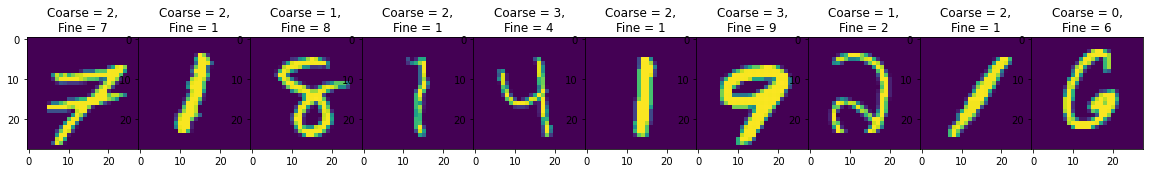

In [4]:
## Import dataset
dataset = datasets.MNIST()
print(dataset.keys())
dataset['tree'].show()


input_shape = dataset['x_train'].shape[1:]
print('INPUT SHAPE:',input_shape,'\n')

print("TRAIN: \r\n")
print(dataset['x_train'].shape)
print(dataset['y_train_fine'].shape)
print(dataset['y_train_coarse'].shape)

print("\nTEST: \r\n")
print(dataset['x_test'].shape)
print(dataset['y_test_fine'].shape)
print(dataset['y_test_coarse'].shape)

fine_class = len(np.unique(np.argmax(dataset['y_test_fine'], axis=1)))
coarse_class = len(np.unique(np.argmax(dataset['y_test_coarse'], axis=1)))
print('\nNumber of Classes in Label Tree:',
      '\nCoarse Level = ',coarse_class,
      '\nFine Level = ',fine_class)

    # Plot Random samples 
datasets.plot_sample_image(dataset['x_train'],
                           {'coarse':dataset['y_train_coarse'],
                            'fine':dataset['y_train_fine']})

## Create ML Model

### Model parameters

In [5]:
initial_lw = MLmodel.initial_lw({"coarse": coarse_class, "fine": fine_class})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : model_params['Reconstruction_LW']
             }

def get_compiled_model():
    model = MLmodel.MNIST_HCapsNet(input_shape,
                                   coarse_class, fine_class)
    model.compile(optimizer='adam',
                  loss=[model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["reconstruction_loss"]],
                  loss_weights=[lossweight['coarse_lw'],
                                lossweight['fine_lw'],
                                lossweight['decoder_lw']],
                  metrics={'Fine_prediction_output_layer': 'accuracy',
                           'Coarse_prediction_output_layer': 'accuracy'}
                 )
    return model

Model: "H-CapsNet_MNIST"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 26, 26, 32)   320         ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 26, 26, 32)  128         ['conv1[0][0]']                  
 alization)                                                                                       
                                                                                                  
 conv2 (Conv2D)                 (None, 24, 24, 64)   18496       ['batch_normalizati

Trainable params: 10,382,577
Non-trainable params: 3,008
__________________________________________________________________________________________________


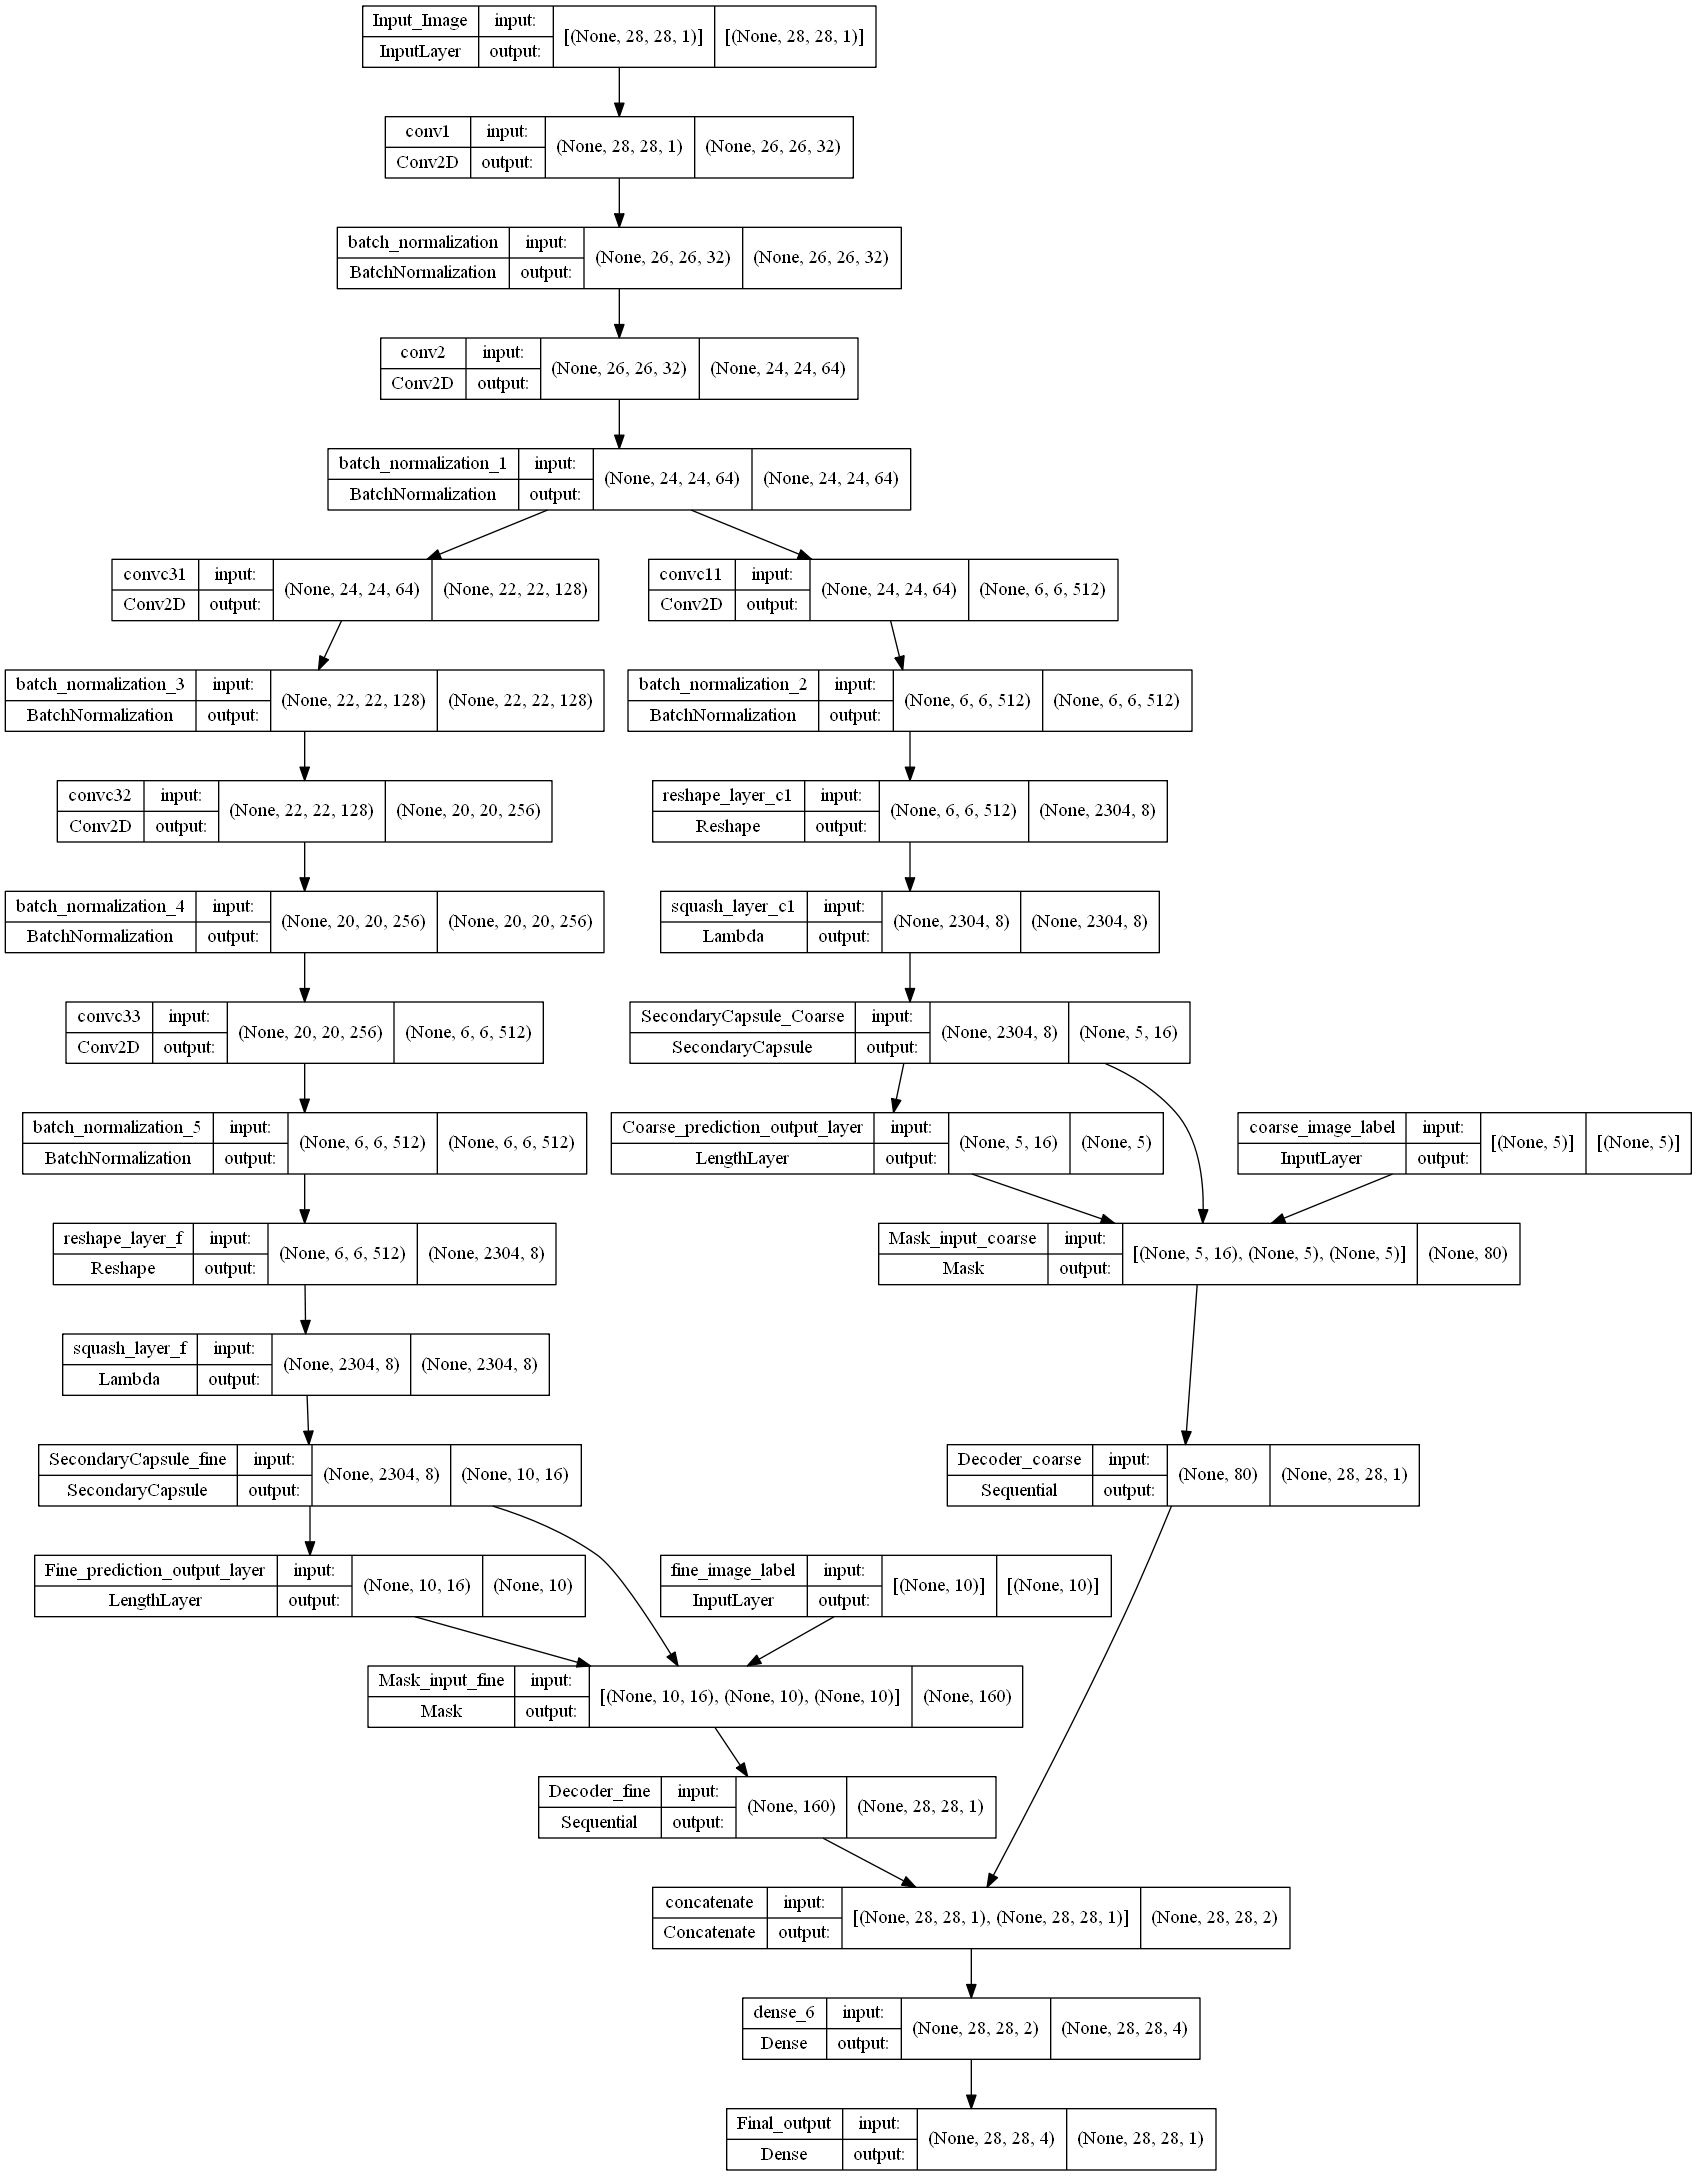

In [6]:
tf.keras.backend.clear_session() ## clear session

model = get_compiled_model()

### Log directory
directory = sysenv.log_dir(dataset["name"]+'/'+model.name)

model.summary()
keras.utils.plot_model(model, to_file = directory+"/H-CapsNet.png", show_shapes=True)

## Model load weight

In [7]:
model.load_weights(directory+'/trained_model.h5')

## Model Analysis

157/157 [==============================] - 12s 43ms/step - loss: 0.0035 - Coarse_prediction_output_layer_loss: 0.0032 - Fine_prediction_output_layer_loss: 0.0041 - Final_output_loss: 0.0376 - Coarse_prediction_output_layer_accuracy: 0.9977 - Fine_prediction_output_layer_accuracy: 0.9958
1. loss ==> 0.0035307591315358877
2. Coarse_prediction_output_layer_loss ==> 0.0032226417679339647
3. Fine_prediction_output_layer_loss ==> 0.004090624861419201
4. Final_output_loss ==> 0.03757922723889351
5. Coarse_prediction_output_layer_accuracy ==> 0.9976999759674072
6. Fine_prediction_output_layer_accuracy ==> 0.9958000183105469
157/157 [==============================] - 7s 38ms/step
  • Confusion_Matrix 

  • COARSE LEVEL 
[[1931    3    4    0    0]
 [   1 1998    3    1    3]
 [   0    2 2161    0    0]
 [   0    2    0 1989    0]
 [   2    1    1    0 1898]]

  • FINE LEVEL 
[[ 980    0    0    0    0    0    0    0    0    0]
 [   0 1134    0    0    0    0    0    1    0    0]
 [   0    0 102

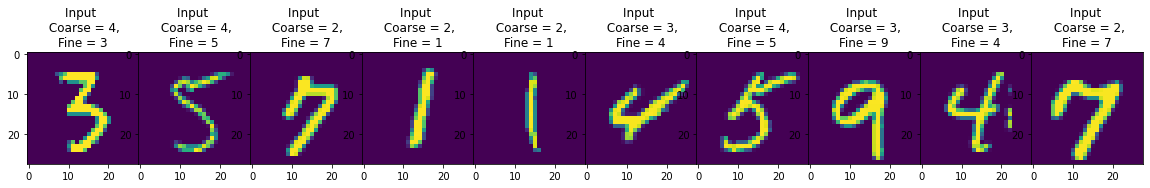

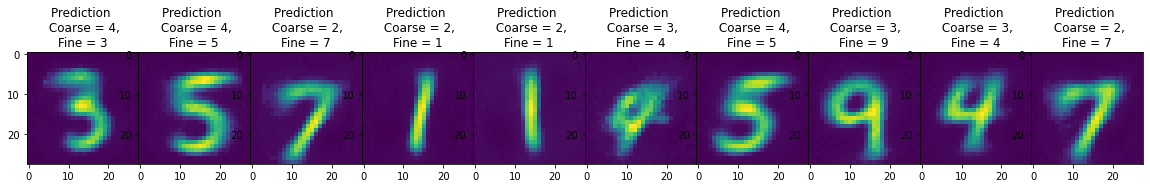

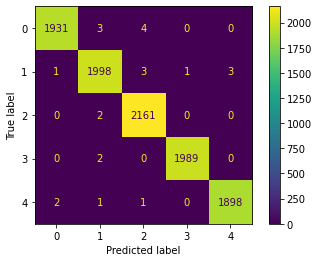

              precision    recall  f1-score   support

           0    0.99845   0.99639   0.99742      1938
           1    0.99601   0.99601   0.99601      2006
           2    0.99631   0.99908   0.99769      2163
           3    0.99950   0.99900   0.99925      1991
           4    0.99842   0.99790   0.99816      1902

    accuracy                        0.99770     10000
   macro avg    0.99774   0.99767   0.99771     10000
weighted avg    0.99770   0.99770   0.99770     10000


  • FINE LEVEL 


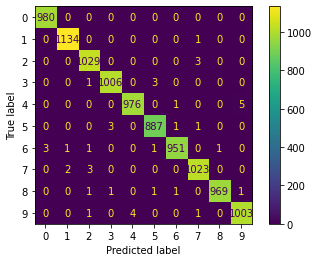

              precision    recall  f1-score   support

           0    0.99695   1.00000   0.99847       980
           1    0.99736   0.99912   0.99824      1135
           2    0.99324   0.99709   0.99516      1032
           3    0.99604   0.99604   0.99604      1010
           4    0.99592   0.99389   0.99490       982
           5    0.99439   0.99439   0.99439       892
           6    0.99686   0.99269   0.99477       958
           7    0.99417   0.99514   0.99465      1028
           8    0.99897   0.99487   0.99691       974
           9    0.99405   0.99405   0.99405      1009

    accuracy                        0.99580     10000
   macro avg    0.99580   0.99573   0.99576     10000
weighted avg    0.99580   0.99580   0.99580     10000


Hierarchical Precision = 0.9968 
Hierarchical Recall = 0.99745 
Hierarchical F1-Score = 0.9970600000000001 
 Consistency =  0.9975 
 Exact Match =  0.9944


In [8]:
model_analysis = MLmodel.model_analysis(model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

true_label = [dataset['y_test_coarse'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1]]
metrics.lvl_wise_metric(true_label,pred_label)

h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )

# EMNIST Dataset

## Import EMNIST dataset

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']
Complete loading training samples as: x_train, y_train
Complete loading test samples as: x_test, y_test
EMNIST dataset: Training have 112,800 samples and testing have 18,800 samples
dict_keys(['x_train', 'y_train_coarse', 'y_train_fine', 'x_test', 'y_test_coarse', 'y_test_fine', 'tree', 'name'])
Root
├── Coarse_0
│   ├── Fine_0
│   ├── Fine_1
│   ├── Fine_2
│   ├── Fine_3
│   ├── Fine_4
│   ├── Fine_5
│   ├── Fine_6
│   ├── Fine_7
│   ├── Fine_8
│   └── Fine_9
└── Coarse_1
    ├── Fine_10
    ├── Fine_11
    ├── Fine_12
    ├── Fine_13
    ├── Fine_14
    ├── Fine_15
    ├── Fine_16
    ├── Fine_17
    ├── Fine_18
    ├── Fine_19
    ├── Fine_20
    ├── Fine_21
    ├── Fine_22
    ├── Fine_23
    ├── Fine_24
    ├── Fine_25
    ├── Fine_26
    ├── Fine_27
    ├── Fine_28
    ├── Fine_29
    ├── Fine_30
    ├── Fine_31
    ├── Fine_32
    ├── Fine_33
    ├── Fine_34
    ├── Fine_35
    ├── Fine_36
    ├── Fine_37
    ├── F

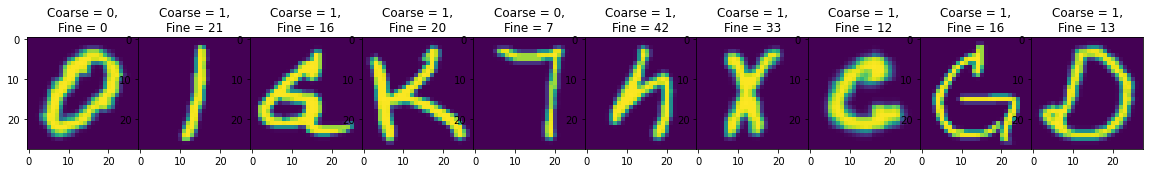

In [14]:
## Import dataset
dataset = datasets.E_MNIST()
print(dataset.keys())
dataset['tree'].show()

input_shape = dataset['x_train'].shape[1:]
print('INPUT SHAPE:',input_shape,'\n')

print("TRAIN: \r\n")
print(dataset['x_train'].shape)
print(dataset['y_train_fine'].shape)
print(dataset['y_train_coarse'].shape)

print("\nTEST: \r\n")
print(dataset['x_test'].shape)
print(dataset['y_test_fine'].shape)
print(dataset['y_train_coarse'].shape)

fine_class = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))
coarse_class = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
print('\nNumber of Classes in Label Tree:',
      '\nCoarse Level = ',coarse_class,
      '\nFine Level = ',fine_class)
    # Plot Random samples 
datasets.plot_sample_image(dataset['x_train'],
                           {'coarse':dataset['y_train_coarse'],
                            'fine':dataset['y_train_fine']})

## Create ML Model

### Model parameters

In [15]:
initial_lw = MLmodel.initial_lw({"coarse": coarse_class, "fine": fine_class})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : model_params['Reconstruction_LW']
             }

def get_compiled_model():
    model = MLmodel.EMNIST_HCapsNet(input_shape,
                                   coarse_class, fine_class)
    model.compile(optimizer='adam',
                  loss=[model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["reconstruction_loss"]],
                  loss_weights=[lossweight['coarse_lw'],
                                lossweight['fine_lw'],
                                lossweight['decoder_lw']],
                  metrics={'Fine_prediction_output_layer': 'accuracy',
                           'Coarse_prediction_output_layer': 'accuracy'}
                 )
    return model

Model: "H-CapsNet_EMNIST"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 26, 26, 32)   320         ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 26, 26, 32)  128         ['conv1[0][0]']                  
 alization)                                                                                       
                                                                                                  
 conv2 (Conv2D)                 (None, 24, 24, 64)   18496       ['batch_normalizat

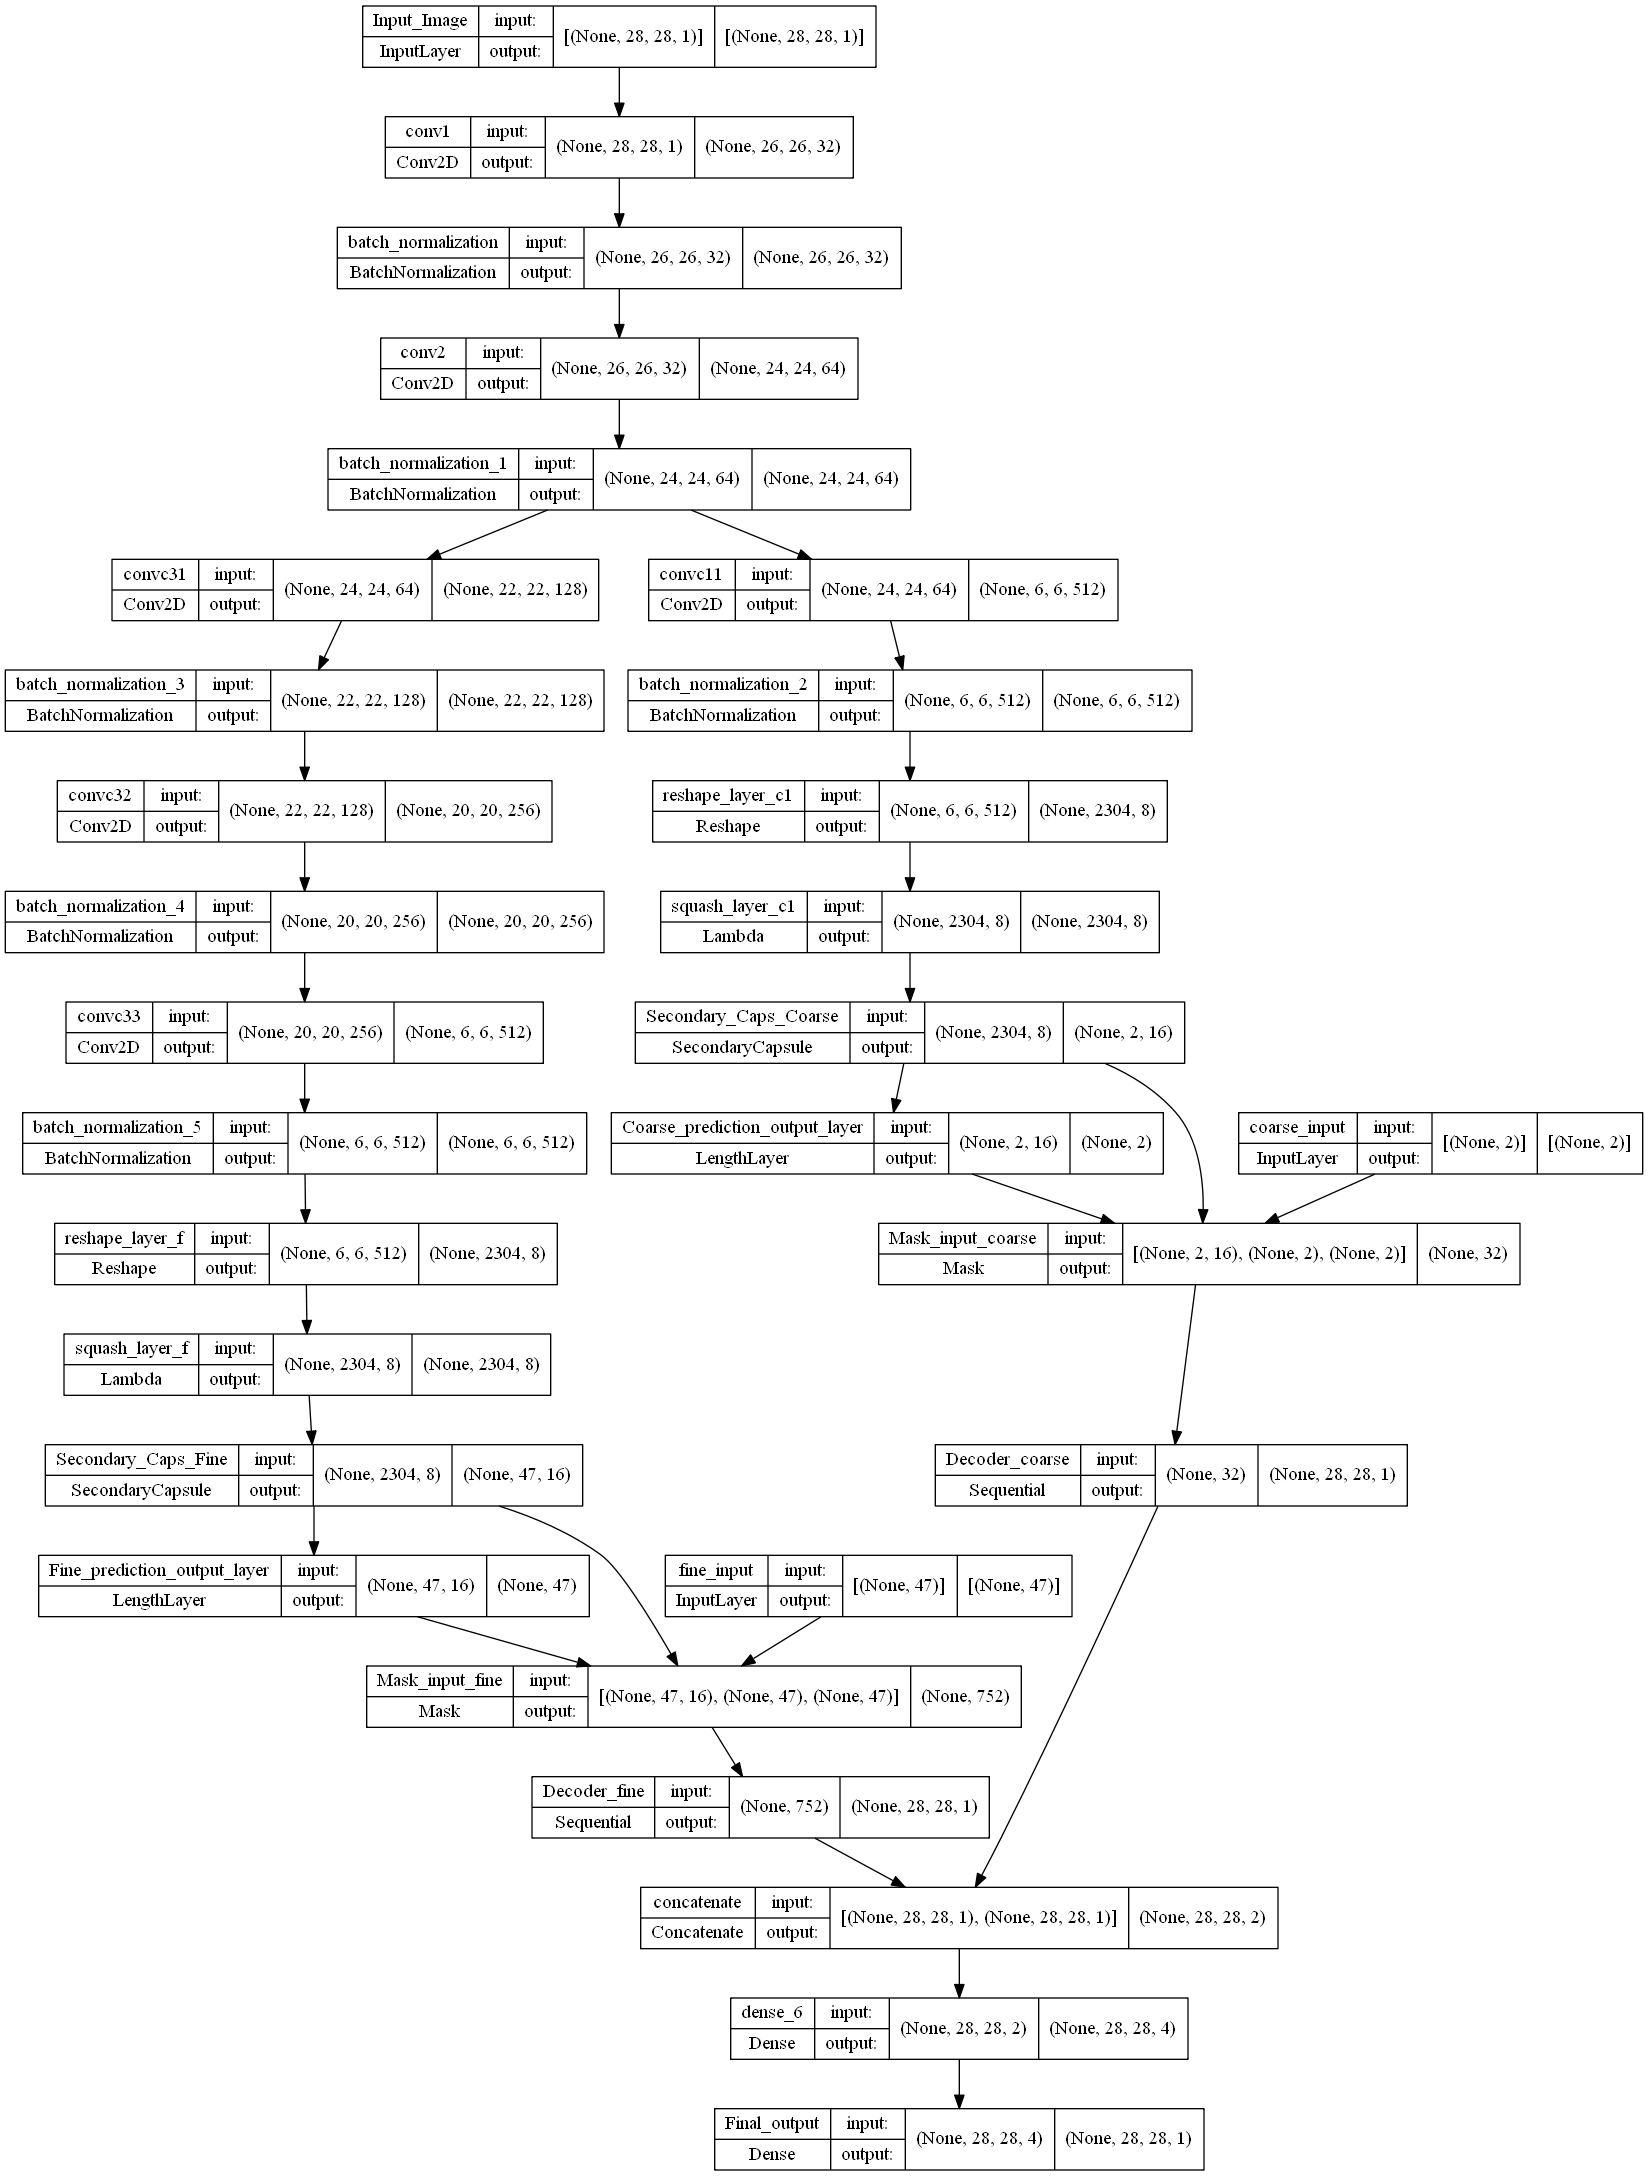

In [16]:
tf.keras.backend.clear_session() ## clear session

model = get_compiled_model()

### Log directory
directory = sysenv.log_dir(dataset["name"]+'/'+model.name)

model.summary()
keras.utils.plot_model(model, to_file = directory+"/H-CapsNet.png", show_shapes=True)

## Model load weight

In [17]:
model.load_weights(directory+'/trained_model.h5')

## Model Analysis

294/294 [==============================] - 32s 103ms/step - loss: 0.0447 - Coarse_prediction_output_layer_loss: 0.0434 - Fine_prediction_output_layer_loss: 0.0743 - Final_output_loss: 0.0634 - Coarse_prediction_output_layer_accuracy: 0.9330 - Fine_prediction_output_layer_accuracy: 0.8998
1. loss ==> 0.04468677565455437
2. Coarse_prediction_output_layer_loss ==> 0.04339265450835228
3. Fine_prediction_output_layer_loss ==> 0.07432190328836441
4. Final_output_loss ==> 0.06341682374477386
5. Coarse_prediction_output_layer_accuracy ==> 0.9329787492752075
6. Fine_prediction_output_layer_accuracy ==> 0.8997872471809387
294/294 [==============================] - 29s 97ms/step
  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 3137   863]
 [  397 14403]]

  • FINE LEVEL 
[[297   0   0 ...   0   0   0]
 [  0 220   0 ...   0   0   0]
 [  0   0 346 ...   0   0   0]
 ...
 [  0   0   0 ... 259   0   0]
 [  0   0   0 ...   0 371   2]
 [  0   0   0 ...   0   1 370]]

  • Classification Report 


  • COARSE L

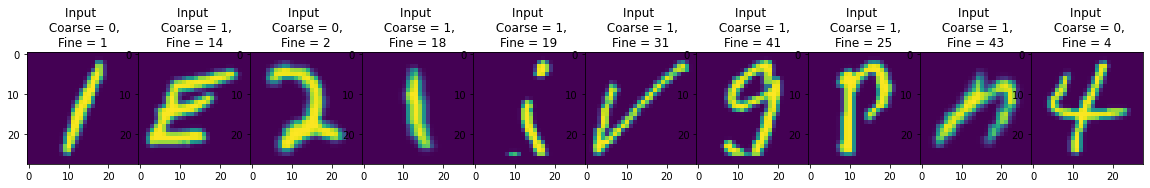

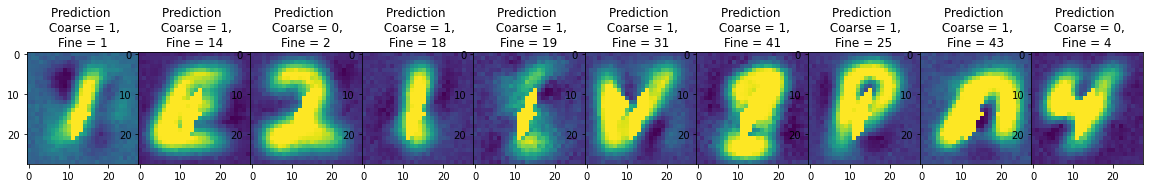

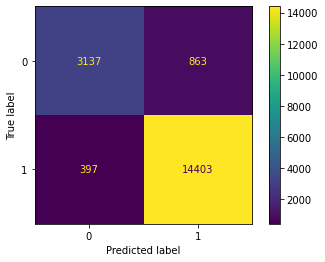

              precision    recall  f1-score   support

           0    0.88766   0.78425   0.83276      4000
           1    0.94347   0.97318   0.95809     14800

    accuracy                        0.93298     18800
   macro avg    0.91557   0.87871   0.89543     18800
weighted avg    0.93160   0.93298   0.93143     18800


  • FINE LEVEL 


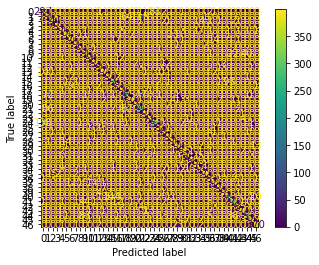

              precision    recall  f1-score   support

           0    0.66742   0.74250   0.70296       400
           1    0.58047   0.55000   0.56483       400
           2    0.94278   0.86500   0.90222       400
           3    0.99254   0.99750   0.99501       400
           4    0.95455   0.94500   0.94975       400
           5    0.95630   0.93000   0.94297       400
           6    0.94000   0.94000   0.94000       400
           7    0.97304   0.99250   0.98267       400
           8    0.96806   0.98500   0.97646       400
           9    0.71702   0.84250   0.77471       400
          10    0.97537   0.99000   0.98263       400
          11    0.98000   0.98000   0.98000       400
          12    0.96750   0.96750   0.96750       400
          13    0.91546   0.94750   0.93120       400
          14    0.98995   0.98500   0.98747       400
          15    0.66593   0.75250   0.70657       400
          16    0.93046   0.97000   0.94982       400
          17    0.96577   0

In [18]:
model_analysis = MLmodel.model_analysis(model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

true_label = [dataset['y_test_coarse'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1]]
metrics.lvl_wise_metric(true_label,pred_label)

h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )

# Fashion-MNIST dataset

## Import Fashion-MNIST dataset

Fashion-MNIST dataset: Training have 60,000 samples and testing have 10,000 samples
dict_keys(['x_train', 'y_train_coarse', 'y_train_medium', 'y_train_fine', 'x_test', 'y_test_coarse', 'y_test_medium', 'y_test_fine', 'tree', 'name'])
Root
├── Coarse_0
│   ├── Medium0
│   │   ├── Fine_0
│   │   ├── Fine_2
│   │   └── Fine_6
│   ├── Medium1
│   │   └── Fine_1
│   ├── Medium2
│   │   └── Fine_3
│   └── Medium3
│       └── Fine_4
└── Coarse_1
    ├── Medium4
    │   └── Fine_8
    └── Medium5
        ├── Fine_5
        ├── Fine_7
        └── Fine_9

INPUT SHAPE: (28, 28, 1) 

TRAIN: 

(60000, 28, 28, 1)
(60000, 10)
(60000, 6)
(60000, 2)

TEST: 

(10000, 28, 28, 1)
(10000, 10)
(10000, 6)
(10000, 2)

Number of Classes in Label Tree: 
Coarse Level =  2 
Medium Level =  6 
Fine Level =  10


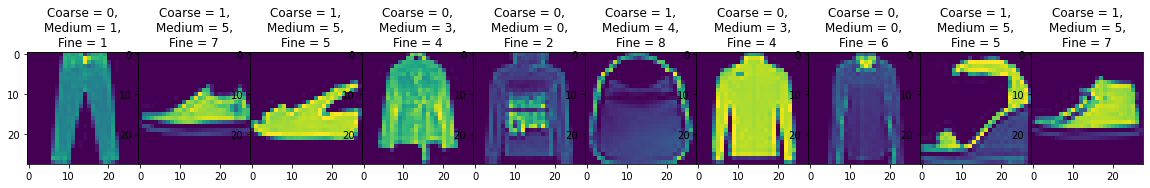

In [19]:
## Import dataset
dataset = datasets.F_MNIST()
print(dataset.keys())
dataset['tree'].show()

input_shape = dataset['x_train'].shape[1:]
print('INPUT SHAPE:',input_shape,'\n')

print("TRAIN: \r\n")
print(dataset['x_train'].shape)
print(dataset['y_train_fine'].shape)
print(dataset['y_train_medium'].shape)
print(dataset['y_train_coarse'].shape)

print("\nTEST: \r\n")
print(dataset['x_test'].shape)
print(dataset['y_test_fine'].shape)
print(dataset['y_test_medium'].shape)
print(dataset['y_test_coarse'].shape)

fine_class = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))
medium_class = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
coarse_class = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
print('\nNumber of Classes in Label Tree:',
      '\nCoarse Level = ',coarse_class,
      '\nMedium Level = ',medium_class,
      '\nFine Level = ',fine_class)

datasets.plot_sample_image(dataset['x_train'],
                           {'coarse':dataset['y_train_coarse'],
                            'medium':dataset['y_train_medium'],
                            'fine':dataset['y_train_fine']})

### Model parameters

In [20]:
initial_lw = MLmodel.initial_lw({"coarse": coarse_class,
                                 "medium": medium_class,
                                 "fine": fine_class})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : model_params['Reconstruction_LW']
             }

def get_compiled_model():
    model = MLmodel.FNIST_HCapsNet(input_shape,
                                     coarse_class, medium_class, fine_class)
    model.compile(optimizer='adam',
                  loss=[model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["reconstruction_loss"]],
                  loss_weights=[lossweight['coarse_lw'],
                                lossweight['medium_lw'],
                                lossweight['fine_lw'],
                                lossweight['decoder_lw']],
                  metrics={'Fine_prediction_output_layer': 'accuracy',
                           'Medium_prediction_output_layer': 'accuracy',
                           'Coarse_prediction_output_layer': 'accuracy'}
                 )
    return model

Model: "H-CapsNet_Fashion-MNSIT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 26, 26, 32)   320         ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 26, 26, 32)  128         ['conv1[0][0]']                  
 alization)                                                                                       
                                                                                                  
 conv2 (Conv2D)                 (None, 24, 24, 64)   18496       ['batch_nor

 r)                                                                                               
                                                                                                  
 coarse1_image_label (InputLaye  [(None, 2)]         0           []                               
 r)                                                                                               
                                                                                                  
 Mask_input_fine (Mask)         (None, 160)          0           ['Secondary_Caps_Fine[0][0]',    
                                                                  'fine_image_label[0][0]',       
                                                                  'Fine_prediction_output_layer[0]
                                                                 [0]']                            
                                                                                                  
 Mask_inpu

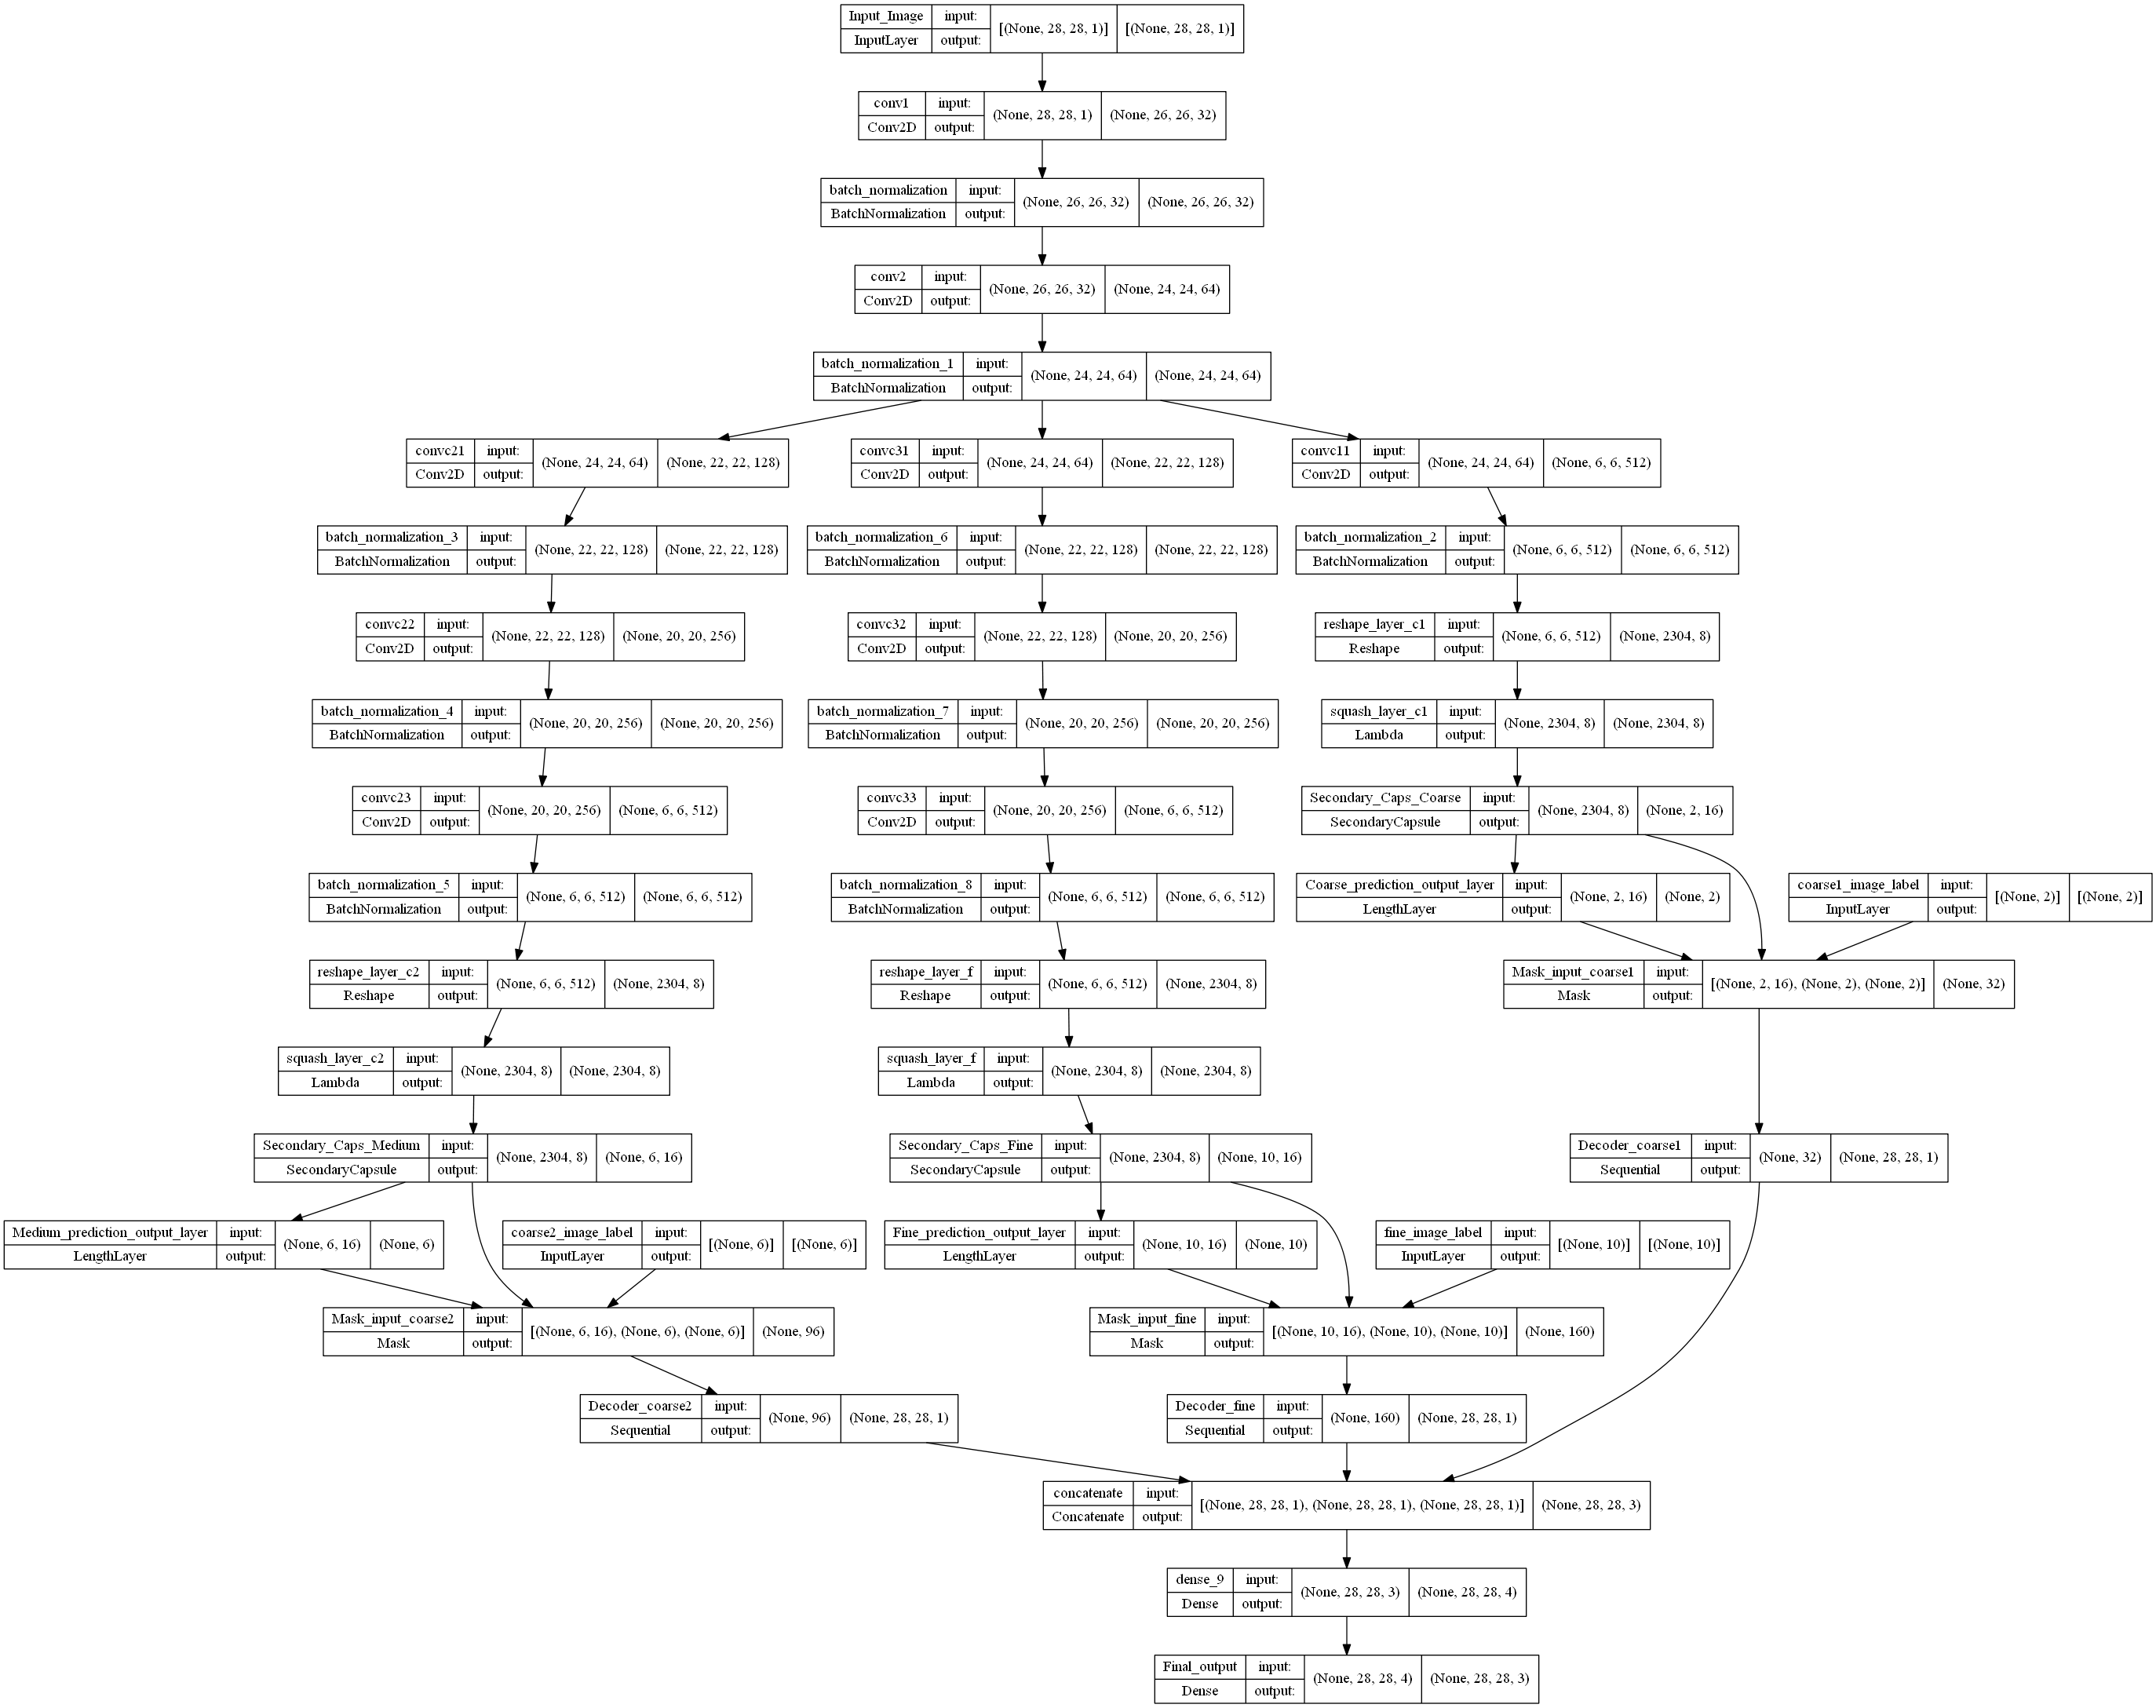

In [21]:
tf.keras.backend.clear_session() ## clear session

model = get_compiled_model()

### Log directory
directory = sysenv.log_dir(dataset["name"]+'/'+model.name)

model.summary()
keras.utils.plot_model(model, to_file = directory+"/H-CapsNet.png", show_shapes=True)

## Model load weight

In [22]:
model.load_weights(directory+'/trained_model.h5')

## Model Analysis

157/157 [==============================] - 10s 54ms/step - loss: 0.0194 - Coarse_prediction_output_layer_loss: 0.0025 - Medium_prediction_output_layer_loss: 0.0228 - Fine_prediction_output_layer_loss: 0.0475 - Final_output_loss: 0.2278 - Coarse_prediction_output_layer_accuracy: 0.9973 - Medium_prediction_output_layer_accuracy: 0.9706 - Fine_prediction_output_layer_accuracy: 0.9395
1. loss ==> 0.01938624680042267
2. Coarse_prediction_output_layer_loss ==> 0.0025462727062404156
3. Medium_prediction_output_layer_loss ==> 0.02278546243906021
4. Fine_prediction_output_layer_loss ==> 0.0474548414349556
5. Final_output_loss ==> 0.22779785096645355
6. Coarse_prediction_output_layer_accuracy ==> 0.9973000288009644
7. Medium_prediction_output_layer_accuracy ==> 0.9706000089645386
8. Fine_prediction_output_layer_accuracy ==> 0.9394999742507935
157/157 [==============================] - 8s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

  • Confusion_Matrix 

  • COARSE LEVEL 
[[5987   13]
 [  14 3986]]

  • MEDIUM LEVEL 
[[2904    2   30   59    4    1]
 [   4  985    7    3    1    0]
 [  65    2  918   14    1    0]
 [  81    0   13  906    0    0]
 [   3    0    1    1  993    2]
 [   0    0    0    0    0 3000]]

  • FINE LEVEL 
[[900   0  13  15   2   0  67   0   3   0]
 [  1 989   1   7   1   0   0   0   1   0]
 [ 14   1 901  10  24   0  50   0   0   0]
 [ 12   2   9 949  10   0  17   0   1   0]
 [  1   1  25  14 913   0  46   0   0   0]
 [  0   0   0   0   0 985   0  11   0   4]
 [ 89   1  24  18  45   0 817   0   6   0]
 [  0   0   0   0   0   4   0 983   0  13]
 [  0   1   0   1   1   1   0   0 996   0]
 [  0   0   0   0   0   8   0  30   0 962]]

  • Classification Report 


  • COARSE LEVEL 


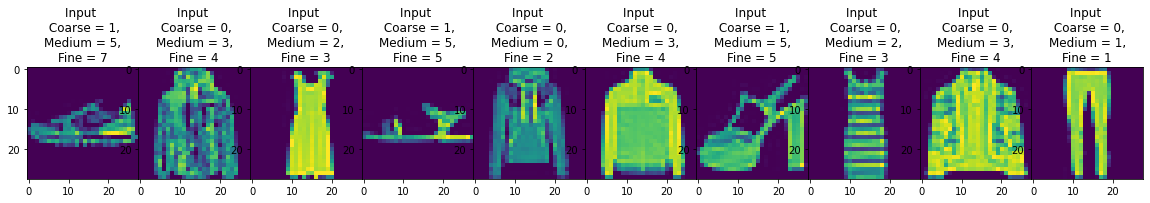

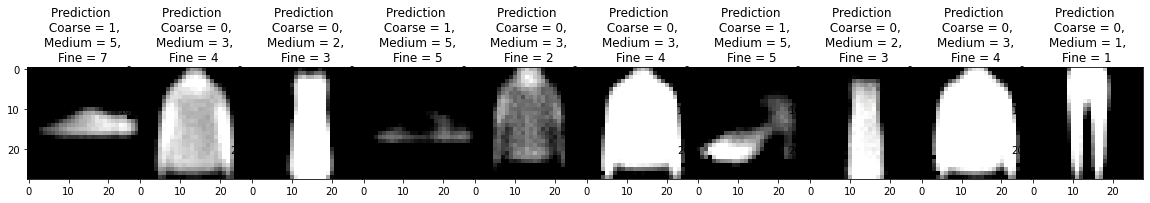

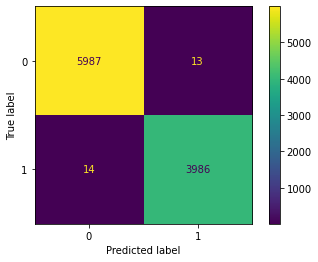

              precision    recall  f1-score   support

           0    0.99767   0.99783   0.99775      6000
           1    0.99675   0.99650   0.99662      4000

    accuracy                        0.99730     10000
   macro avg    0.99721   0.99717   0.99719     10000
weighted avg    0.99730   0.99730   0.99730     10000


  • MEDIUM LEVEL 


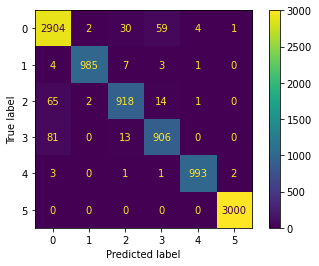

              precision    recall  f1-score   support

           0    0.94995   0.96800   0.95889      3000
           1    0.99596   0.98500   0.99045      1000
           2    0.94737   0.91800   0.93245      1000
           3    0.92167   0.90600   0.91377      1000
           4    0.99399   0.99300   0.99350      1000
           5    0.99900   1.00000   0.99950      3000

    accuracy                        0.97060     10000
   macro avg    0.96799   0.96167   0.96476     10000
weighted avg    0.97058   0.97060   0.97053     10000


  • FINE LEVEL 


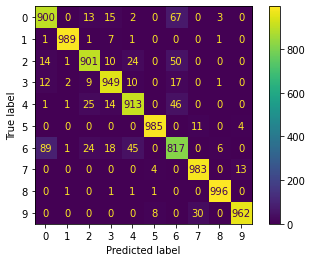

              precision    recall  f1-score   support

           0    0.88496   0.90000   0.89241      1000
           1    0.99397   0.98900   0.99148      1000
           2    0.92600   0.90100   0.91333      1000
           3    0.93590   0.94900   0.94240      1000
           4    0.91667   0.91300   0.91483      1000
           5    0.98697   0.98500   0.98599      1000
           6    0.81946   0.81700   0.81823      1000
           7    0.95996   0.98300   0.97134      1000
           8    0.98908   0.99600   0.99253      1000
           9    0.98264   0.96200   0.97221      1000

    accuracy                        0.93950     10000
   macro avg    0.93956   0.93950   0.93947     10000
weighted avg    0.93956   0.93950   0.93947     10000


Hierarchical Precision = 0.9685799999999999 
Hierarchical Recall = 0.9736333333333334 
Hierarchical F1-Score = 0.9707285714285714 
 Consistency =  0.976 
 Exact Match =  0.9269


In [23]:
model_analysis = MLmodel.model_analysis(model, dataset)

results = model_analysis.evaluate()

predictions = model_analysis.prediction()

true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )

# CIFAR-10 Dataset

## Import CIFAR-10 dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples
dict_keys(['x_train', 'y_train_coarse', 'y_train_medium', 'y_train_fine', 'x_test', 'y_test_coarse', 'y_test_medium', 'y_test_fine', 'tree', 'name'])
Root
├── Coarse_0
│   ├── Medium0
│   │   └── Fine_0
│   ├── Medium1
│   │   └── Fine_8
│   └── Medium2
│       ├── Fine_1
│       └── Fine_9
└── Coarse_1
    ├── Medium3
    │   └── Fine_2
    ├── Medium4
    │   └── Fine_6
    ├── Medium5
    │   ├── Fine_3
    │   └── Fine_5
    └── Medium6
        ├── Fine_4
        └── Fine_7

INPUT SHAPE: (32, 32, 3) 

TRAIN: 

(50000, 32, 32, 3)
(50000, 10)
(50000, 7)
(50000, 2)

TEST: 

(10000, 32, 32, 3)
(10000, 10)
(10000, 7)
(10000, 2)

Number of Classes in Label Tree: 
Coarse Level =  2 
Medium Level =  7 
Fine Level =  10


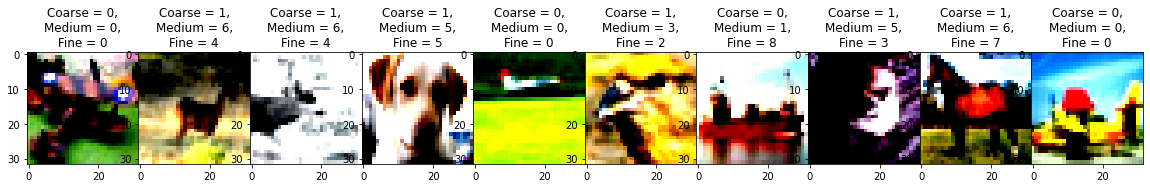

In [24]:
## Import dataset
dataset = datasets.CIFAR10()
print(dataset.keys())
dataset['tree'].show()

input_shape = dataset['x_train'].shape[1:]
print('INPUT SHAPE:',input_shape,'\n')

print("TRAIN: \r\n")
print(dataset['x_train'].shape)
print(dataset['y_train_fine'].shape)
print(dataset['y_train_medium'].shape)
print(dataset['y_train_coarse'].shape)

print("\nTEST: \r\n")
print(dataset['x_test'].shape)
print(dataset['y_test_fine'].shape)
print(dataset['y_test_medium'].shape)
print(dataset['y_test_coarse'].shape)

fine_class = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))
medium_class = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
coarse_class = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
print('\nNumber of Classes in Label Tree:',
      '\nCoarse Level = ',coarse_class,
      '\nMedium Level = ',medium_class,
      '\nFine Level = ',fine_class)
datasets.plot_sample_image(dataset['x_train'],
                           {'coarse':dataset['y_train_coarse'],
                            'medium':dataset['y_train_medium'],
                            'fine':dataset['y_train_fine']})

### Model parameters

In [25]:
initial_lw = MLmodel.initial_lw({"coarse": coarse_class,
                                 "medium": medium_class,
                                 "fine": fine_class})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : model_params['Reconstruction_LW']
             }

def get_compiled_model():
    model = MLmodel.CIFAR10_HCapsNet(input_shape,
                                     coarse_class, medium_class, fine_class)
    model.compile(optimizer='adam',
                  loss=[model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["reconstruction_loss"]],
                  loss_weights=[lossweight['coarse_lw'],
                                lossweight['medium_lw'],
                                lossweight['fine_lw'],
                                lossweight['decoder_lw']],
                  metrics={'Fine_prediction_output_layer': 'accuracy',
                           'Medium_prediction_output_layer': 'accuracy',
                           'Coarse_prediction_output_layer': 'accuracy'}
                 )
    return model

Model: "H-CapsNet_CIFAR10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 30, 30, 32)   896         ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 30, 30, 32)  128         ['conv1[0][0]']                  
 alization)                                                                                       
                                                                                                  
 conv2 (Conv2D)                 (None, 28, 28, 64)   18496       ['batch_normaliza

 r)                                                                                               
                                                                                                  
 coarse1_image_label (InputLaye  [(None, 2)]         0           []                               
 r)                                                                                               
                                                                                                  
 Mask_input_fine (Mask)         (None, 160)          0           ['Secondary_Caps_Fine[0][0]',    
                                                                  'fine_image_label[0][0]',       
                                                                  'Fine_prediction_output_layer[0]
                                                                 [0]']                            
                                                                                                  
 Mask_inpu

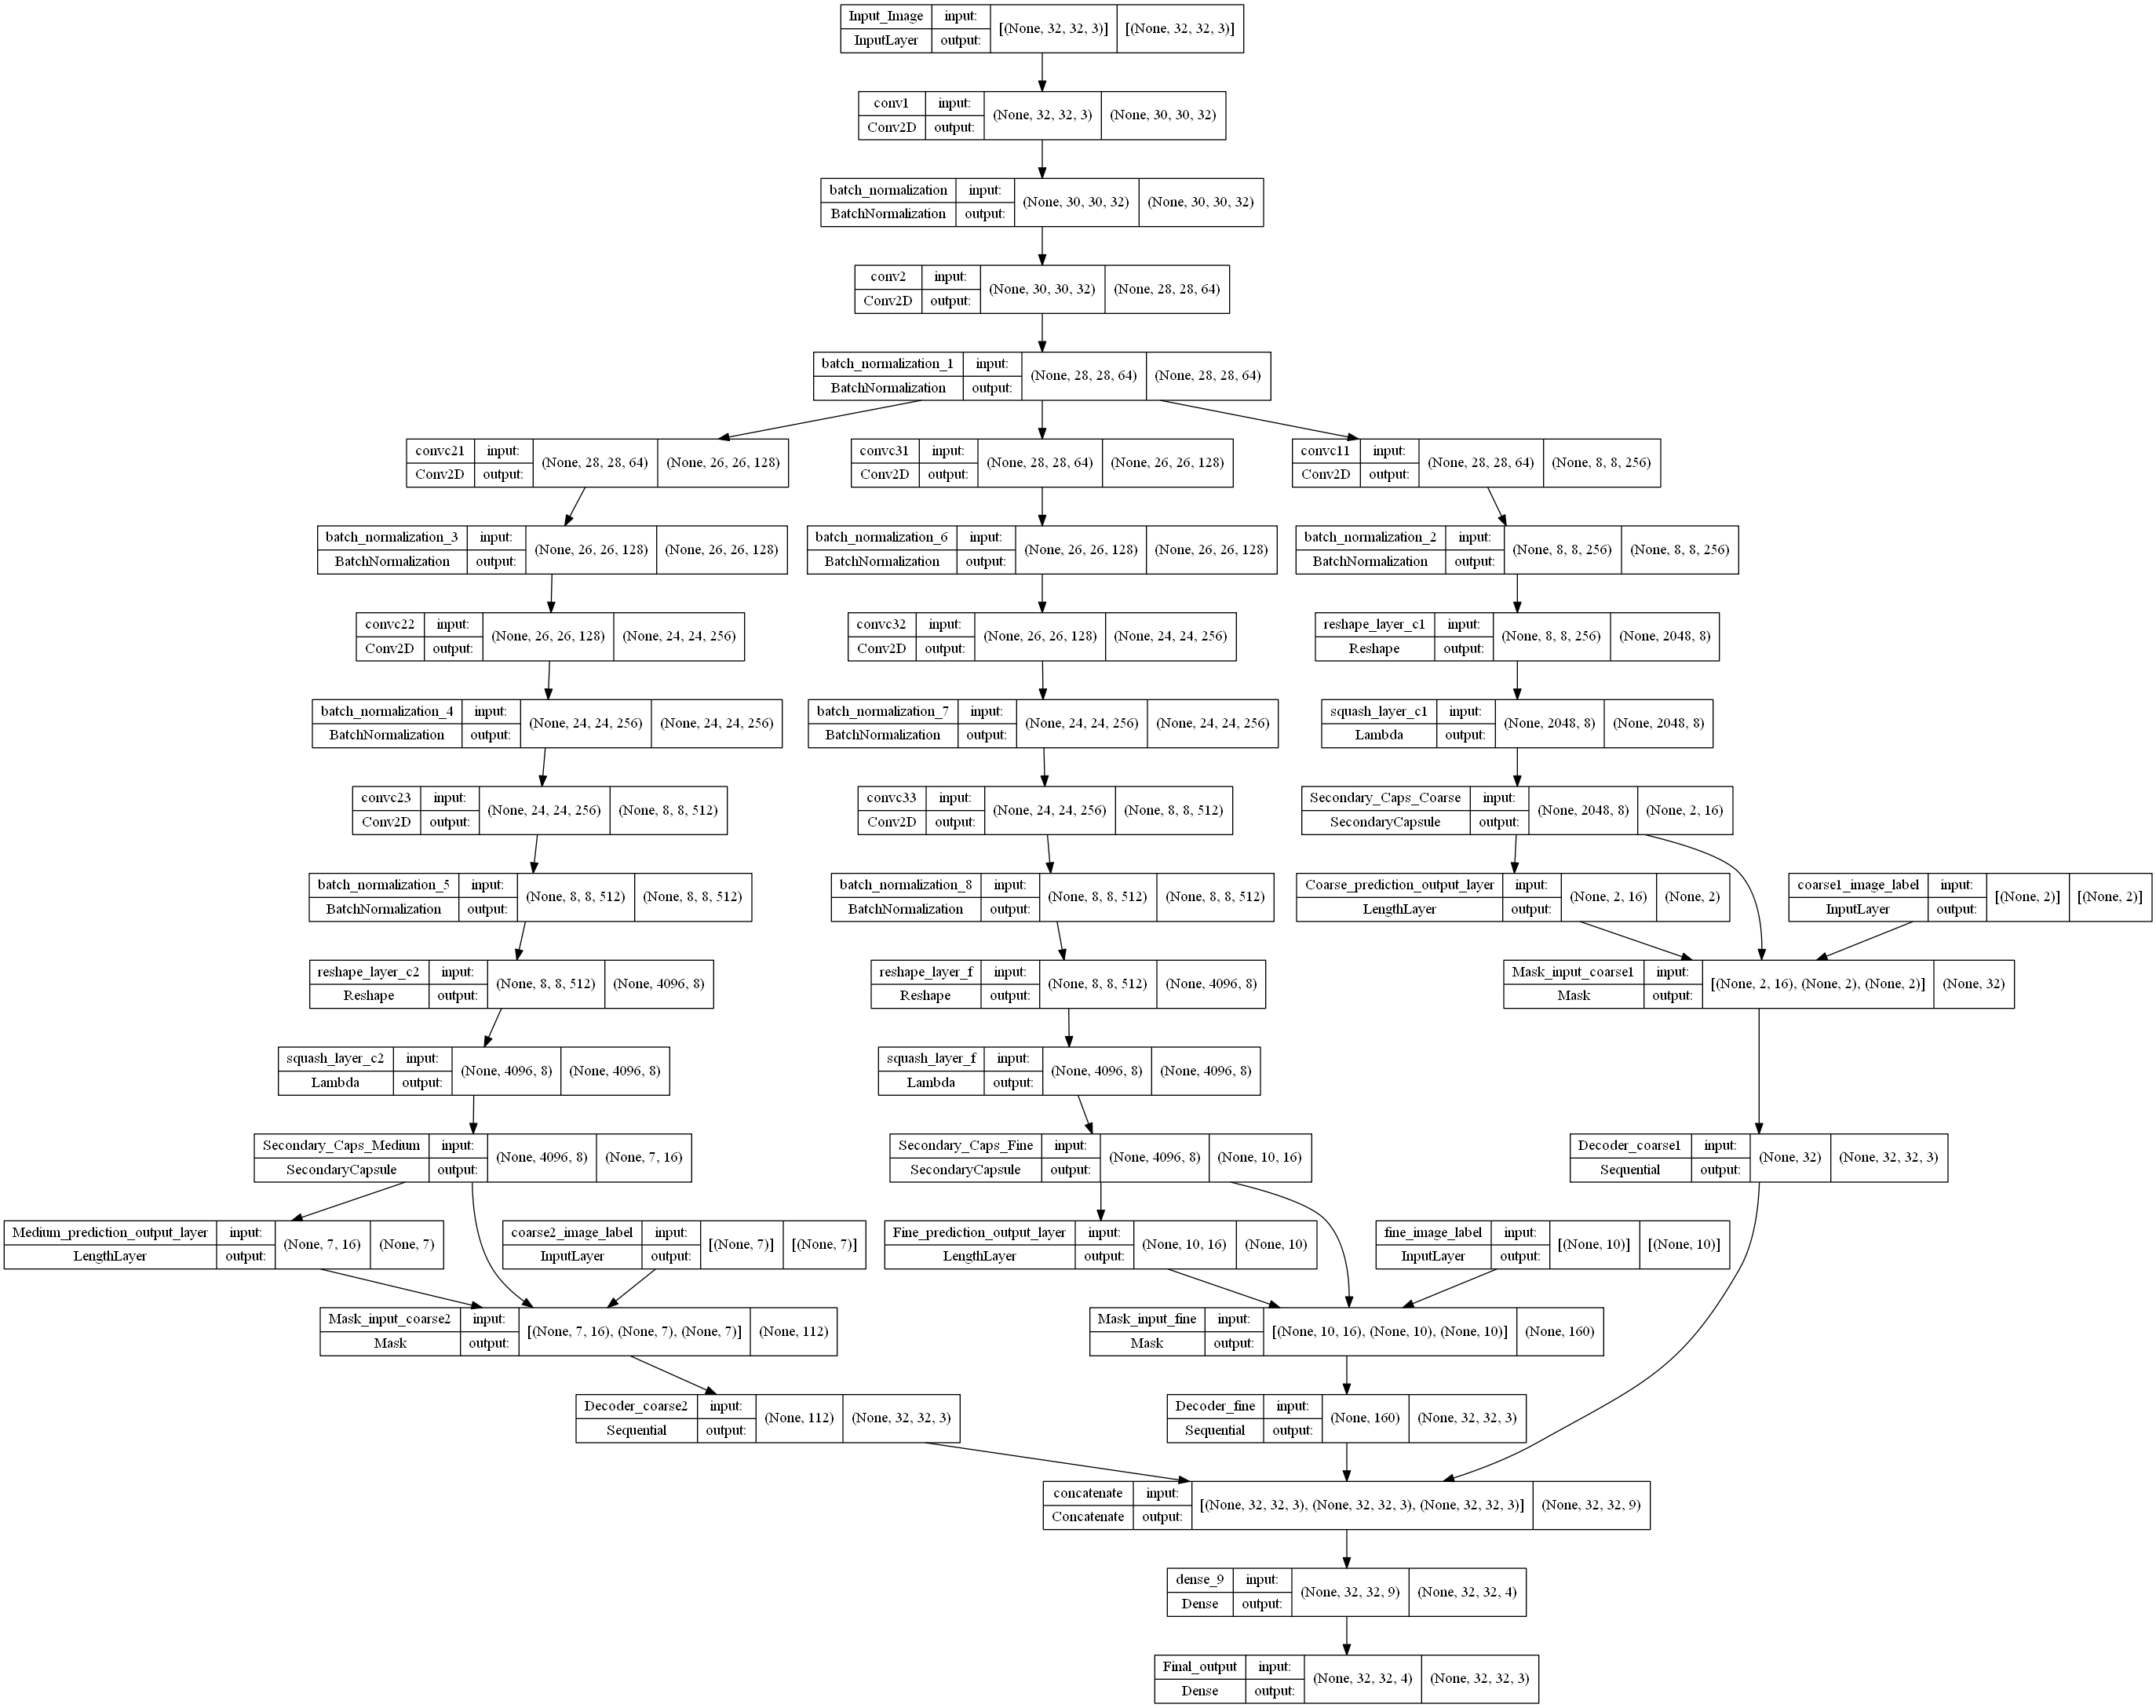

In [26]:
tf.keras.backend.clear_session() ## clear session

model = get_compiled_model()

### Log directory
directory = sysenv.log_dir(dataset["name"]+'/'+model.name)

model.summary()
keras.utils.plot_model(model, to_file = directory+"/H-CapsNet.png", show_shapes=True)

## Model load weight

In [27]:
model.load_weights(directory+'/trained_model.h5')

## Model Analysis

157/157 [==============================] - 15s 81ms/step - loss: 0.0602 - Coarse_prediction_output_layer_loss: 0.0315 - Medium_prediction_output_layer_loss: 0.0751 - Fine_prediction_output_layer_loss: 0.0932 - Final_output_loss: 0.6495 - Coarse_prediction_output_layer_accuracy: 0.9627 - Medium_prediction_output_layer_accuracy: 0.9172 - Fine_prediction_output_layer_accuracy: 0.8968
1. loss ==> 0.06020689755678177
2. Coarse_prediction_output_layer_loss ==> 0.03154054284095764
3. Medium_prediction_output_layer_loss ==> 0.07506194710731506
4. Fine_prediction_output_layer_loss ==> 0.09317649900913239
5. Final_output_loss ==> 0.6495137810707092
6. Coarse_prediction_output_layer_accuracy ==> 0.9627000093460083
7. Medium_prediction_output_layer_accuracy ==> 0.9172000288963318
8. Fine_prediction_output_layer_accuracy ==> 0.8967999815940857
157/157 [==============================] - 12s 73ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

  • Confusion_Matrix 

  • COARSE LEVEL 
[[3824  176]
 [ 197 5803]]

  • MEDIUM LEVEL 
[[ 911   21   25   20    8    7    8]
 [  20  934   30    6    4    5    1]
 [   9    5 1970    3    5    5    3]
 [  36    2    5  812   41   53   51]
 [   7    1    2   14  948   18   10]
 [  16    8   23   34   60 1772   87]
 [  11    4    8   36   38   78 1825]]

  • FINE LEVEL 
[[914   9  23   7   5   0   5   8  18  11]
 [  5 956   2   2   1   2   2   1   4  25]
 [ 40   2 835  27  28  16  32  13   5   2]
 [ 12   6  39 785  30  65  38  15   5   5]
 [  3   2  27  19 892  11  29  15   1   1]
 [  5   2  24  76  15 836  21  14   3   4]
 [  7   1  13  11   3   1 961   0   1   2]
 [  8   0  13  12  18  14   6 927   0   2]
 [ 27  10   8   4   1   1   1   1 935  12]
 [ 12  32   5   5   1   2   6   1   9 927]]

  • Classification Report 


  • COARSE LEVEL 


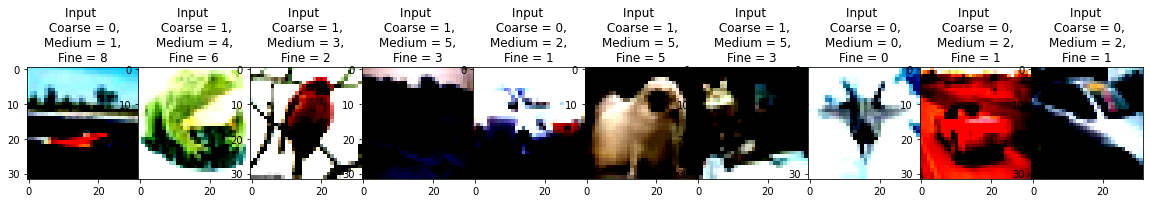

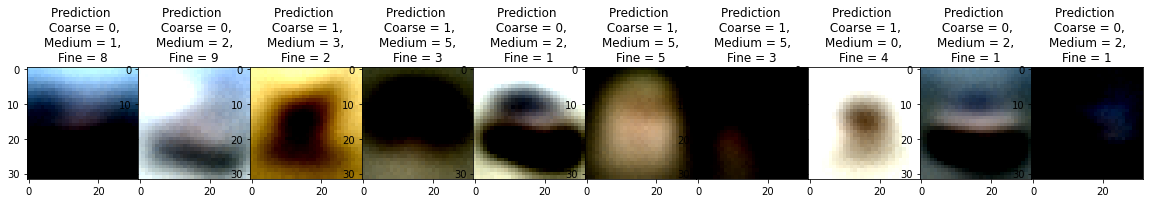

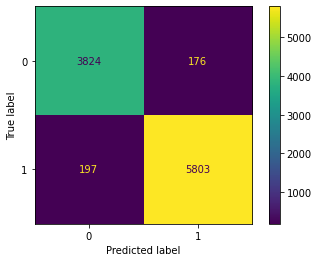

              precision    recall  f1-score   support

           0    0.95101   0.95600   0.95350      4000
           1    0.97056   0.96717   0.96886      6000

    accuracy                        0.96270     10000
   macro avg    0.96079   0.96158   0.96118     10000
weighted avg    0.96274   0.96270   0.96272     10000


  • MEDIUM LEVEL 


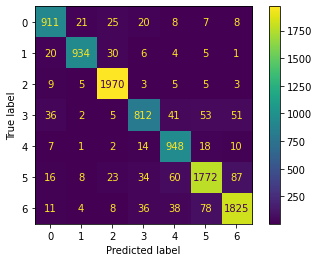

              precision    recall  f1-score   support

           0    0.90198   0.91100   0.90647      1000
           1    0.95795   0.93400   0.94582      1000
           2    0.95492   0.98500   0.96973      2000
           3    0.87784   0.81200   0.84364      1000
           4    0.85870   0.94800   0.90114      1000
           5    0.91434   0.88600   0.89995      2000
           6    0.91940   0.91250   0.91593      2000

    accuracy                        0.91720     10000
   macro avg    0.91216   0.91264   0.91181     10000
weighted avg    0.91738   0.91720   0.91683     10000


  • FINE LEVEL 


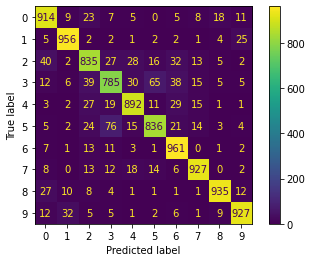

              precision    recall  f1-score   support

           0    0.88480   0.91400   0.89916      1000
           1    0.93725   0.95600   0.94653      1000
           2    0.84429   0.83500   0.83962      1000
           3    0.82806   0.78500   0.80595      1000
           4    0.89738   0.89200   0.89468      1000
           5    0.88186   0.83600   0.85832      1000
           6    0.87284   0.96100   0.91480      1000
           7    0.93166   0.92700   0.92932      1000
           8    0.95311   0.93500   0.94397      1000
           9    0.93542   0.92700   0.93119      1000

    accuracy                        0.89680     10000
   macro avg    0.89667   0.89680   0.89636     10000
weighted avg    0.89667   0.89680   0.89636     10000


Hierarchical Precision = 0.92458 
Hierarchical Recall = 0.9484666666666666 
Hierarchical F1-Score = 0.9344535714285713 
 Consistency =  0.8916 
 Exact Match =  0.8412


In [28]:
model_analysis = MLmodel.model_analysis(model, dataset)

results = model_analysis.evaluate()

predictions = model_analysis.prediction()

true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )

# CIFAR-100 Dataset

## Import CIFAR-100 dataset

CIFAR-100 dataset: Training have 50,000 samples and testing have 10,000 samples
dict_keys(['x_train', 'y_train_coarse', 'y_train_medium', 'y_train_fine', 'x_test', 'y_test_coarse', 'y_test_medium', 'y_test_fine', 'tree', 'name'])
Root
├── Coarse_0
│   ├── Medium0
│   │   ├── Fine_30
│   │   ├── Fine_4
│   │   ├── Fine_55
│   │   ├── Fine_72
│   │   └── Fine_95
│   └── Medium1
│       ├── Fine_1
│       ├── Fine_32
│       ├── Fine_67
│       ├── Fine_73
│       └── Fine_91
├── Coarse_1
│   ├── Medium17
│   │   ├── Fine_47
│   │   ├── Fine_52
│   │   ├── Fine_56
│   │   ├── Fine_59
│   │   └── Fine_96
│   ├── Medium2
│   │   ├── Fine_54
│   │   ├── Fine_62
│   │   ├── Fine_70
│   │   ├── Fine_82
│   │   └── Fine_92
│   └── Medium4
│       ├── Fine_0
│       ├── Fine_51
│       ├── Fine_53
│       ├── Fine_57
│       └── Fine_83
├── Coarse_2
│   ├── Medium3
│   │   ├── Fine_10
│   │   ├── Fine_16
│   │   ├── Fine_28
│   │   ├── Fine_61
│   │   └── Fine_9
│   ├── Medium5
│   │   ├── Fine_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

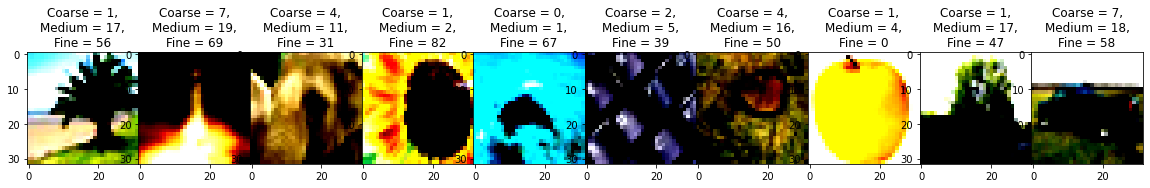

In [4]:
## Import dataset
dataset = datasets.CIFAR100()
print(dataset.keys())
dataset['tree'].show()

input_shape = dataset['x_train'].shape[1:]
print('INPUT SHAPE:',input_shape,'\n')

print("TRAIN: \r\n")
print(dataset['x_train'].shape)
print(dataset['y_train_fine'].shape)
print(dataset['y_train_medium'].shape)
print(dataset['y_train_coarse'].shape)

print("\nTEST: \r\n")
print(dataset['x_test'].shape)
print(dataset['y_test_fine'].shape)
print(dataset['y_test_medium'].shape)
print(dataset['y_test_coarse'].shape)

fine_class = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))
medium_class = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
coarse_class = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
print('\nNumber of Classes in Label Tree:',
      '\nCoarse Level = ',coarse_class,
      '\nMedium Level = ',medium_class,
      '\nFine Level = ',fine_class)

datasets.plot_sample_image(dataset['x_train'],
                           {'coarse':dataset['y_train_coarse'],
                            'medium':dataset['y_train_medium'],
                            'fine':dataset['y_train_fine']})

### Model parameters

In [5]:
initial_lw = MLmodel.initial_lw({"coarse": coarse_class,
                                 "medium": medium_class,
                                 "fine": fine_class})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : model_params['Reconstruction_LW']
             }

def get_compiled_model():
    model = MLmodel.CIFAR100_HCapsNet(input_shape,
                                     coarse_class, medium_class, fine_class)
    model.compile(optimizer='adam',
                  loss=[model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["reconstruction_loss"]],
                  loss_weights=[lossweight['coarse_lw'],
                                lossweight['medium_lw'],
                                lossweight['fine_lw'],
                                lossweight['decoder_lw']],
                  metrics={'Fine_prediction_output_layer': 'accuracy',
                           'Medium_prediction_output_layer': 'accuracy',
                           'Coarse_prediction_output_layer': 'accuracy'}
                 )
    return model

Model: "H-CapsNet_CIFAR100"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 30, 30, 32)   896         ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 30, 30, 32)  128         ['conv1[0][0]']                  
 alization)                                                                                       
                                                                                                  
 conv2 (Conv2D)                 (None, 28, 28, 64)   18496       ['batch_normaliz

 fine_image_label (InputLayer)  [(None, 100)]        0           []                               
                                                                                                  
 coarse2_image_label (InputLaye  [(None, 20)]        0           []                               
 r)                                                                                               
                                                                                                  
 coarse1_image_label (InputLaye  [(None, 8)]         0           []                               
 r)                                                                                               
                                                                                                  
 Mask_input_fine (Mask)         (None, 1600)         0           ['Secondary_Caps_Fine[0][0]',    
                                                                  'fine_image_label[0][0]',       
          

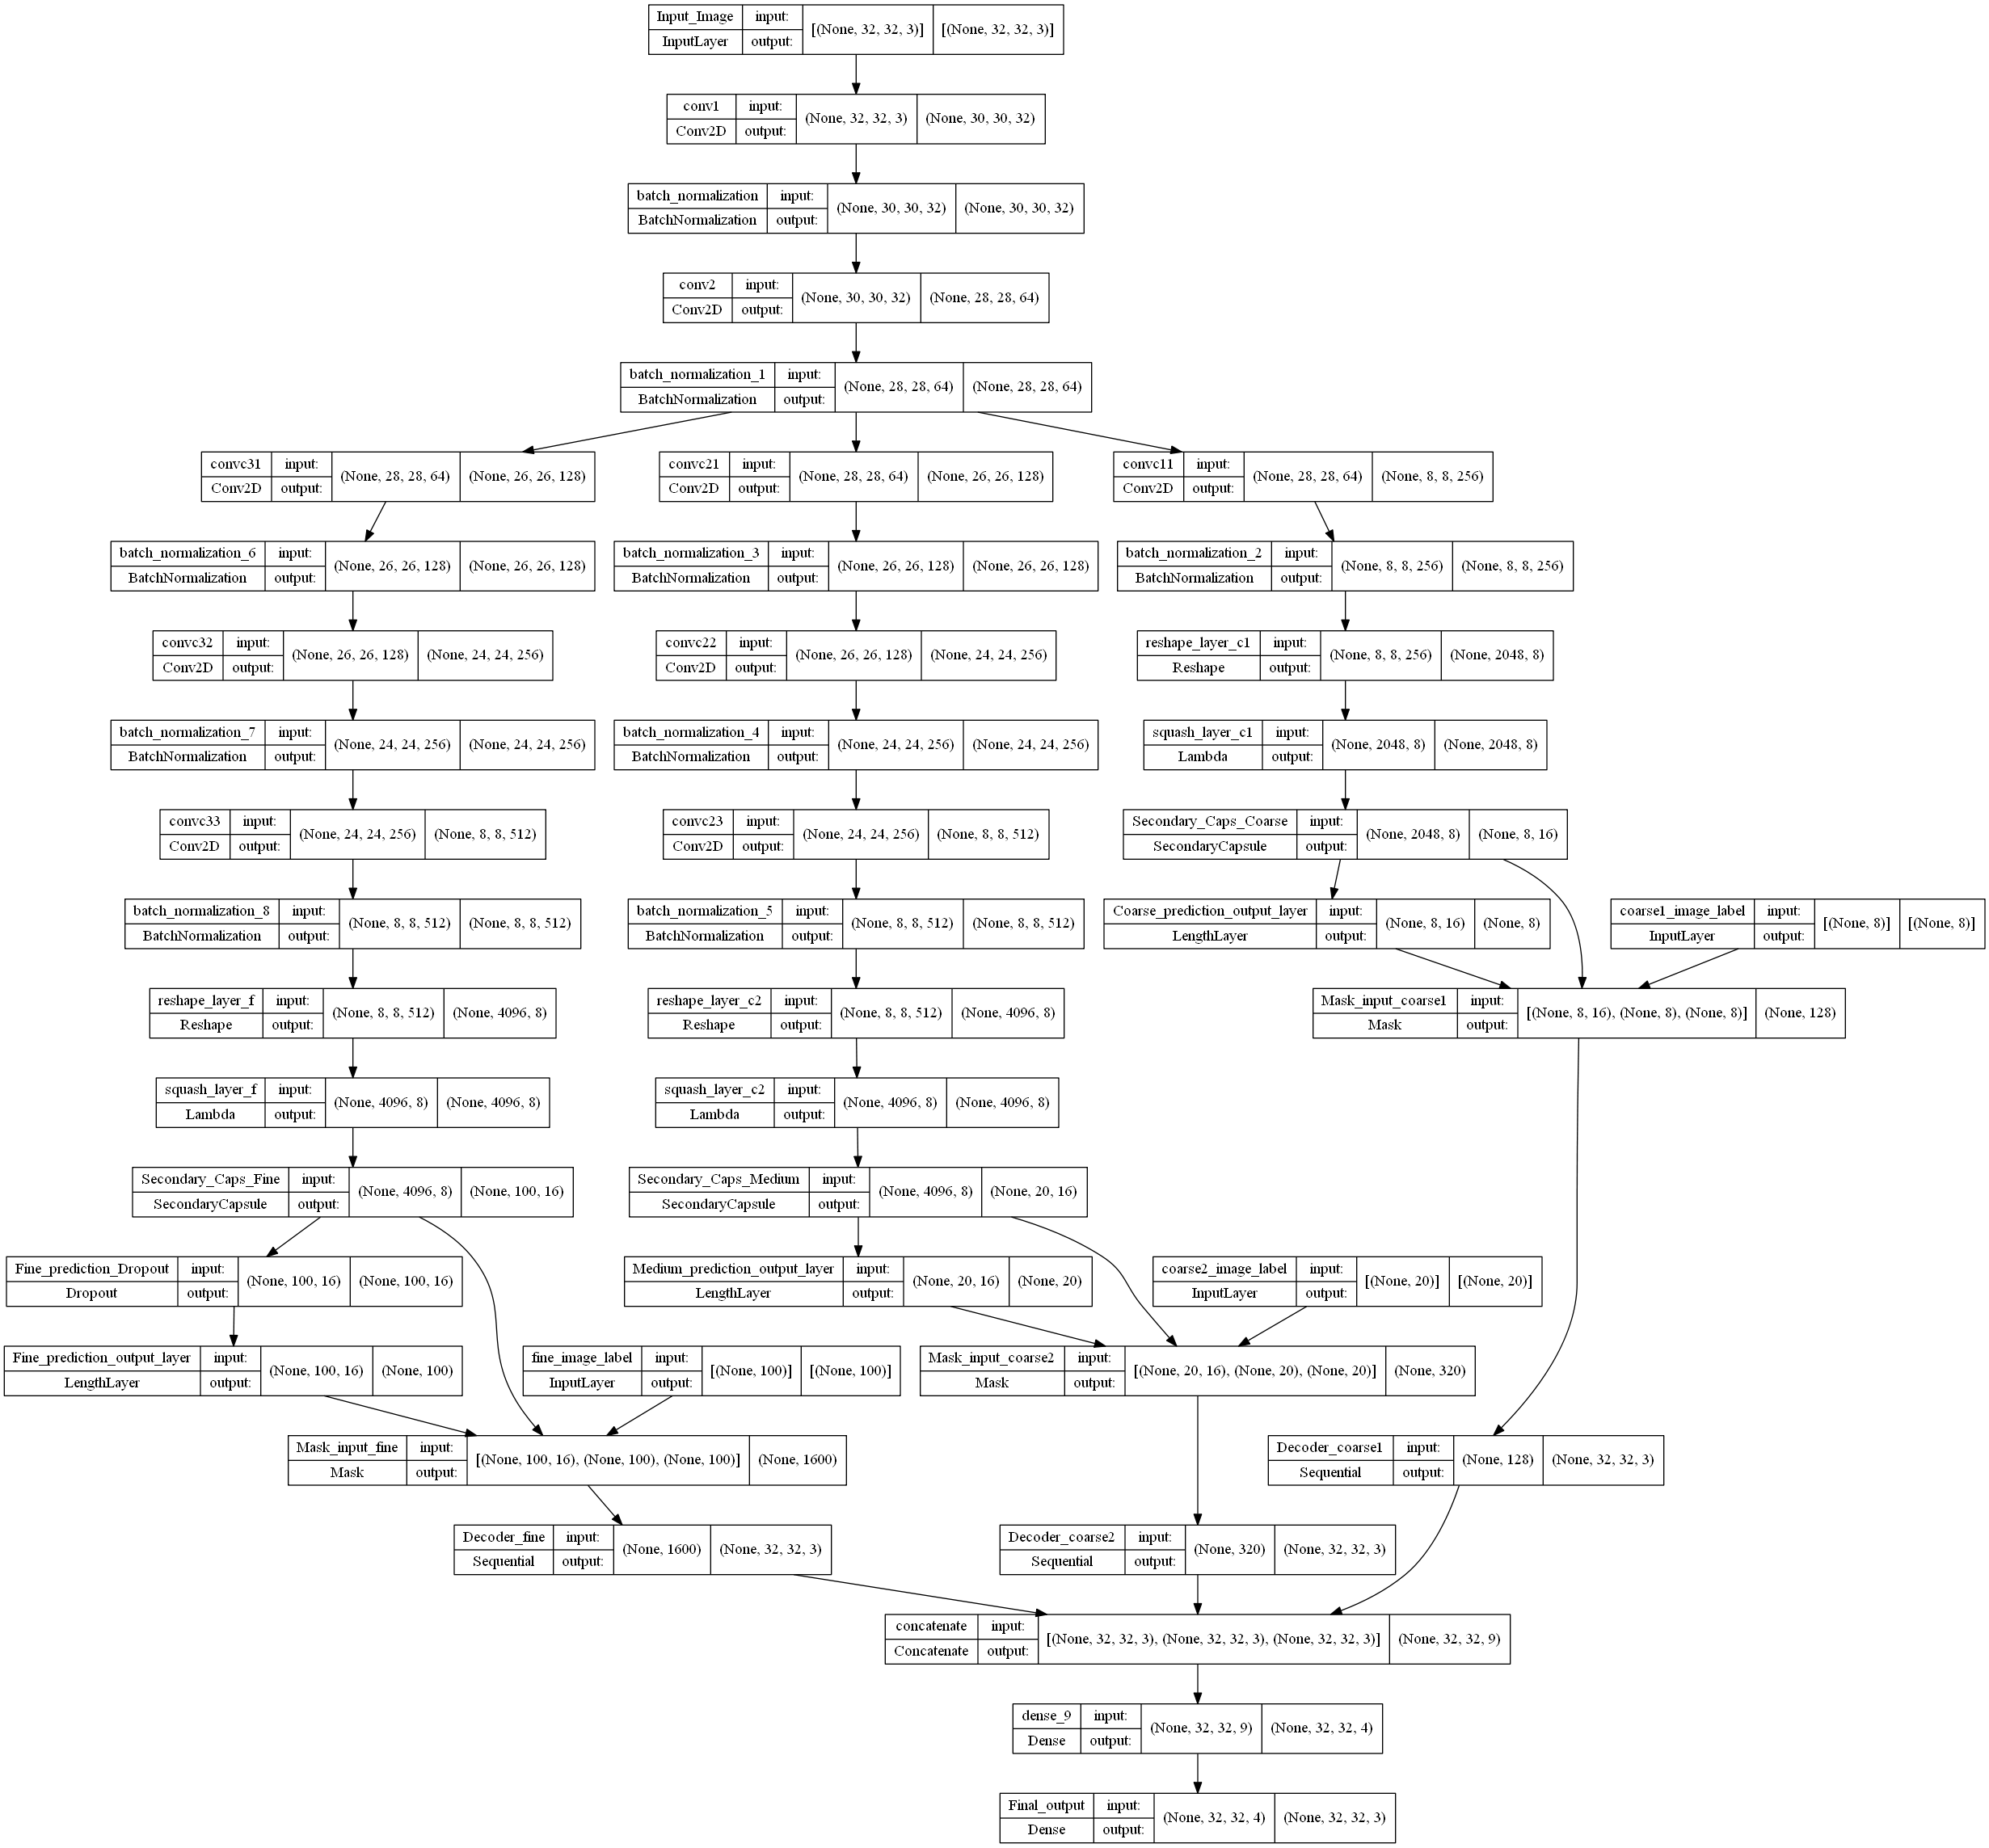

In [6]:
tf.keras.backend.clear_session() ## clear session

model = get_compiled_model()

### Log directory
directory = sysenv.log_dir(dataset["name"]+'/'+model.name)

model.summary()
keras.utils.plot_model(model, to_file = directory+"/H-CapsNet.png", show_shapes=True)

## Model load weight

In [7]:
model.load_weights(directory+'/trained_model.h5')

## Model Analysis

625/625 [==============================] - 90s 116ms/step - loss: 0.2272 - Coarse_prediction_output_layer_loss: 0.2077 - Medium_prediction_output_layer_loss: 0.2321 - Fine_prediction_output_layer_loss: 0.2897 - Final_output_loss: 0.5380 - Coarse_prediction_output_layer_accuracy: 0.7470 - Medium_prediction_output_layer_accuracy: 0.7417 - Fine_prediction_output_layer_accuracy: 0.6783
1. loss ==> 0.2272234857082367
2. Coarse_prediction_output_layer_loss ==> 0.20766274631023407
3. Medium_prediction_output_layer_loss ==> 0.23212109506130219
4. Fine_prediction_output_layer_loss ==> 0.2897034287452698
5. Final_output_loss ==> 0.5380160808563232
6. Coarse_prediction_output_layer_accuracy ==> 0.746999979019165
7. Medium_prediction_output_layer_accuracy ==> 0.7416999936103821
8. Fine_prediction_output_layer_accuracy ==> 0.6783000230789185
625/625 [==============================] - 75s 105ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 460   33   40   58  358   20   10   21]
 [   4 1223   52   71   98   27    5   20]
 [  13   31 1204   47   86   21   14   84]
 [  27   51   74  631  185    8    5   19]
 [  59   42   96  129 2083   33   11   47]
 [  17   33   44   18   65  754    0   69]
 [   1   26   23   22   81    5  330   12]
 [   8   15   40   30   75   47    0  785]]

  • MEDIUM LEVEL 
[[282  27   0   3   2   2   5   8  33   4  10  11  27  17   4  34  21   3
    5   2]
 [ 32 333   8   5   4   3   4  11   6   2   7   5  12  17   9  25   9   0
    4   4]
 [  2   6 431   0  15   4   3  17   1   1   2   0   1   7   1   6   0   1
    1   1]
 [  0   2   7 368  16  35  11   5   5   9   1   1   3  10   7   3   4   0
    3  10]
 [  2   3  13   9 403   8   2  11   7   2   2   4   3  16   1   9   1   2
    1   1]
 [  3   3   2  26   6 357  29   3   6   6   5   3   5  11   7   4   5   3
    4  12]
 [  1   3   4  10   0  15 422   3   4   6   2   0   1   3   7   5   0   1
    6   7]


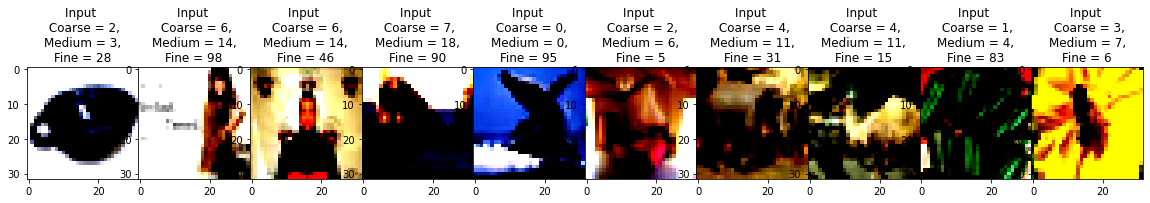

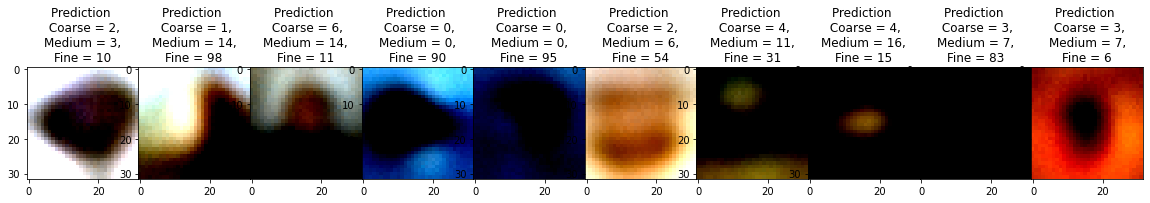

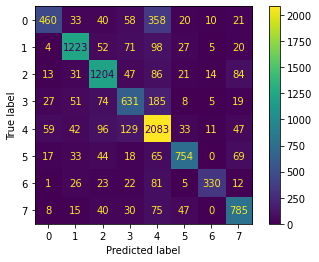

              precision    recall  f1-score   support

           0    0.78098   0.46000   0.57898      1000
           1    0.84113   0.81533   0.82803      1500
           2    0.76542   0.80267   0.78360      1500
           3    0.62724   0.63100   0.62911      1000
           4    0.68723   0.83320   0.75321      2500
           5    0.82404   0.75400   0.78747      1000
           6    0.88000   0.66000   0.75429       500
           7    0.74267   0.78500   0.76325      1000

    accuracy                        0.74700     10000
   macro avg    0.76859   0.71765   0.73474     10000
weighted avg    0.75428   0.74700   0.74364     10000


  • MEDIUM LEVEL 


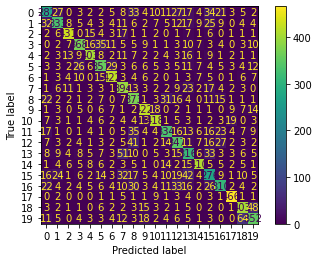

              precision    recall  f1-score   support

           0    0.64384   0.56400   0.60128       500
           1    0.74831   0.66600   0.70476       500
           2    0.87071   0.86200   0.86633       500
           3    0.79654   0.73600   0.76507       500
           4    0.83437   0.80600   0.81994       500
           5    0.72414   0.71400   0.71903       500
           6    0.83235   0.84400   0.83813       500
           7    0.66893   0.78800   0.72360       500
           8    0.62270   0.74600   0.67880       500
           9    0.81625   0.84400   0.82989       500
          10    0.83101   0.83600   0.83350       500
          11    0.74058   0.66800   0.70242       500
          12    0.65970   0.69400   0.67641       500
          13    0.58627   0.63200   0.60828       500
          14    0.86134   0.82000   0.84016       500
          15    0.55533   0.55200   0.55366       500
          16    0.70455   0.62000   0.65957       500
          17    0.89272   0

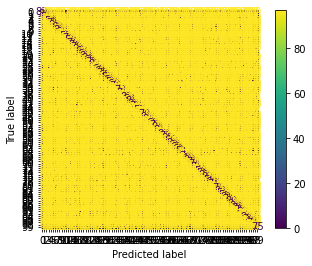

              precision    recall  f1-score   support

           0    0.87234   0.82000   0.84536       100
           1    0.74074   0.80000   0.76923       100
           2    0.60204   0.59000   0.59596       100
           3    0.64286   0.45000   0.52941       100
           4    0.54206   0.58000   0.56039       100
           5    0.68269   0.71000   0.69608       100
           6    0.67480   0.83000   0.74439       100
           7    0.65979   0.64000   0.64975       100
           8    0.72174   0.83000   0.77209       100
           9    0.83951   0.68000   0.75138       100
          10    0.56338   0.40000   0.46784       100
          11    0.59770   0.52000   0.55615       100
          12    0.66038   0.70000   0.67961       100
          13    0.73684   0.56000   0.63636       100
          14    0.55474   0.76000   0.64135       100
          15    0.71698   0.76000   0.73786       100
          16    0.72165   0.70000   0.71066       100
          17    0.82353   0

In [8]:
model_analysis = MLmodel.model_analysis(model, dataset,batch_size=16)

results = model_analysis.evaluate()

predictions = model_analysis.prediction()

true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,pred_label,dataset['tree'])

print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )